# NATURAL LANGUAGE PROCESSING WITH TRANSFORMERS
# Α Pos Tagger trained on UD treebank with fine-tuning a BERT model

# Native BERT implementation

In [1]:
# First install some extra packages
# ! pip install pyconll # for UD treebank reading
# ! pip install bert-tensorflow # for using bert model 
# tensorflow version == 1.14.0

In [2]:
import pyconll, pickle, os, random, datetime, warnings, gc, urllib.request, zipfile, collections
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import recall_score, precision_score, classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV, learning_curve, cross_val_score
from sklearn import preprocessing
from sklearn.exceptions import UndefinedMetricWarning

from IPython.display import Image 
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

import pandas as pd

In [3]:
def plot_confusion_matrix(f1,
                          cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          i=1):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    plt.figure(figsize=(10, 6))
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}; f1-score={:0.4f}'.format(accuracy, misclass, f1))

In [4]:
# def download_files():
#     print('Downloading English treebank...')
#     urllib.request.urlretrieve('http://archive.aueb.gr:8085/files/en_partut-ud-dev.conllu', UD_ENGLISH_DEV)
#     urllib.request.urlretrieve('http://archive.aueb.gr:8085/files/en_partut-ud-test.conllu', UD_ENGLISH_TEST)
#     urllib.request.urlretrieve('http://archive.aueb.gr:8085/files/en_partut-ud-train.conllu', UD_ENGLISH_TRAIN)
#     print('Treebank downloaded.')
#     print('Downloading pre-trained BERT model...')
#     urllib.request.urlretrieve('https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip', 'uncased_L-12_H-768_A-12.zip')
#     print('Pre-trained BERT model downloaded.')
#     print('Extracting zip file...')
#     zip_ref = zipfile.ZipFile('uncased_L-12_H-768_A-12.zip', 'r')
#     zip_ref.extractall('.')
#     zip_ref.close()
#     print('Zip file extracted.')

First we download English treebank and pre-trained BERT model:

In [5]:
# download_files()

# Preprocessing

In [6]:
# def read_conllu(path):
#     data = pyconll.load_from_file(path)
#     tagged_sentences=[]
#     t=0
#     for sentence in data:
#         tagged_sentence=[]
#         for token in sentence:
#             if token.upos and token.form:
#                 t+=1
#                 tagged_sentence.append((token.form.lower(), token.upos))
#         tagged_sentences.append(tagged_sentence)
#     return tagged_sentences

In [7]:
def read_data(path):
    table = pd.read_table(path).fillna('X')
    data = table.values 
    X, X_ = [], [] # store input sequence
    Y, Y_ = [], [] # store output sequence
    for word in data:
        if word[0] is not '.':         
            X_.append(word[0])  # entity[0] contains the word
            Y_.append(word[2])  # entity[1] contains corresponding tag
        else:        
            X_.append('.')
            Y_.append('PUNC')
            X.append(X_)
            Y.append(Y_)
            X_ = []
            Y_ = []
        
    return X,Y


Load train, development and test set in the appropriate tagged format, tuple (word, pos-tag)

In [8]:
UD_ENGLISH_TRAIN = 'C:/Users/dell/Desktop/nlp/NLAPOST2021-main/train/nr.gold.train'
UD_ENGLISH_DEV = 'C:/Users/dell/Desktop/nlp/NLAPOST2021-main/dev/nr.gold.dev'
# UD_ENGLISH_TEST = 'en_partut-ud-test.conllu'

In [9]:
train_text, train_label = read_data(UD_ENGLISH_TRAIN)
val_text, val_label = read_data(UD_ENGLISH_DEV)
# test_sentences = read_conllu(UD_ENGLISH_TEST)

# split entire data into training and testing sets
TEST_SIZE = 0.15
train_text, test_text, train_label, test_label = train_test_split(train_text, train_label, test_size=TEST_SIZE, random_state=4)

Print some statistics

In [10]:
MAX_SEQUENCE_LENGTH=len(max(train_text+val_text+test_text, key=len))
print('Max sentence length:',MAX_SEQUENCE_LENGTH)

Max sentence length: 103


In [11]:
train_text[0:1], train_label[0:1]

([['Iinkomba',
   'kufanele',
   'zifaneleke',
   ',',
   'zanele',
   ',',
   'zinqophe',
   ',',
   'zimedeke',
   ',',
   'zonge',
   'imali',
   'begodu',
   'zitholakale',
   '.']],
 [['N',
   'V',
   'V',
   'PUNC',
   'V',
   'PUNC',
   'V',
   'PUNC',
   'V',
   'PUNC',
   'V',
   'N',
   'CONJ',
   'V',
   'PUNC']])

Convert our UD dataset to NER conllu format and save in 'data' directory:

In [12]:
def convert_ner_format(text, label, file):
    with open(file, 'w') as f:
        words=0
        i=0
        for zip_i in zip(text, label):
            a, b = tuple(zip_i)
            for r in range(len(a)):
                item = a[r]+' '+b[r]
                f.write("%s\n" % item)
                words+=1
            f.write("\n")
            i+=1
            #if i==3: break
    print('Sentences:',i,'Words:',words)

In [13]:
convert_ner_format(train_text, train_label, 'data/train.txt')
convert_ner_format(test_text, test_label, 'data/test.txt')
convert_ner_format(val_text, val_label, 'data/dev.txt')

Sentences: 2338 Words: 37560
Sentences: 413 Words: 7103
Sentences: 2 Words: 42


# Run BERT fine-tuning

In [14]:
MAX_SEQUENCE_LENGTH = MAX_SEQUENCE_LENGTH+2 # +2 for [CLS], [SEP] tokens

In [15]:
!rm -rf ./output/result_dir/* 

'rm' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


In [16]:
%run bert_pos.py \
    --data_dir=data \
    --task_name="POS" \
    --do_lower_case=False \
    --crf=False \
    --do_train=True \
    --do_eval=True \
    --do_predict=True  \
    --vocab_file=multi_cased_L-12_H-768_A-12/vocab.txt \
    --bert_config_file=multi_cased_L-12_H-768_A-12/bert_config.json \
    --init_checkpoint=multi_cased_L-12_H-768_A-12/bert_model.ckpt \
    --max_seq_length=$MAX_SEQUENCE_LENGTH \
    --train_batch_size=16 \
    --learning_rate=2e-5 \
    --num_train_epochs=4.0 \
    --output_dir=./output/result_dir

C:\Users\dell\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\dell\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\dell\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\dell\AppData\

W0829 21:41:43.554743  6600 estimator.py:1984] Estimator's model_fn (<function model_fn_builder.<locals>.model_fn at 0x0000016761F4DF78>) includes params argument, but params are not passed to Estimator.


INFO:tensorflow:Using config: {'_model_dir': './output/result_dir', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000016761E886C8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=1000, num_shards=8, num_cores_per_replica=None, per_host_input_for_training=3, t

I0829 21:41:43.560740  6600 estimator.py:209] Using config: {'_model_dir': './output/result_dir', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000016761E886C8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=1000, num_shards=8, num_cores_per_replica=None, pe

INFO:tensorflow:_TPUContext: eval_on_tpu True


I0829 21:41:43.566746  6600 tpu_context.py:209] _TPUContext: eval_on_tpu True


W0829 21:41:43.573743  6600 tpu_context.py:211] eval_on_tpu ignored because use_tpu is False.


W0829 21:41:43.577742  6600 deprecation_wrapper.py:119] From c:\Users\dell\Desktop\nlp\pos-tagger-bert-tensorflow-master\bert_pos.py:329: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.

I0829 21:41:43.589744  6600 bert_pos.py:334] Writing example 0 of 2338
I0829 21:41:43.605747  6600 bert_pos.py:311] *** Example ***
I0829 21:41:43.607743  6600 bert_pos.py:312] guid: train-0
I0829 21:41:43.608744  6600 bert_pos.py:314] tokens: I ##inko ##mba ku ##fan ##ele zif ##ane ##lek ##e , za ##nele , zin ##q ##op ##he , zi ##mede ##ke , zon ##ge imali be ##go ##du zit ##hola ##kale .
I0829 21:41:43.610744  6600 bert_pos.py:315] input_ids: 101 146 107113 17714 15694 24049 12739 14663 12822 26776 10112 117 10339 106261 117 99830 11703 13362 11643 117 57087 59268 10550 117 80973 10525 52488 10347 10797 11460 84265 95912 60526 119 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

W0829 21:41:52.142196  6600 deprecation_wrapper.py:119] From c:\Users\dell\Desktop\nlp\pos-tagger-bert-tensorflow-master\bert_pos.py:355: The name tf.FixedLenFeature is deprecated. Please use tf.io.FixedLenFeature instead.



Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


W0829 21:41:52.231196  6600 deprecation.py:323] From C:\Users\dell\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\training\training_util.py:236: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


W0829 21:41:52.416421  6600 deprecation.py:323] From c:\Users\dell\Desktop\nlp\pos-tagger-bert-tensorflow-master\bert_pos.py:379: map_and_batch (from tensorflow.python.data.experimental.ops.batching) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


W0829 21:41:52.446891  6600 deprecation_wrapper.py:119] From c:\Users\dell\Desktop\nlp\pos-tagger-bert-tensorflow-master\bert_pos.py:362: The name tf.parse_single_example is deprecated. Please use tf.io.parse_single_example instead.



Instructions for updating:
Use `tf.cast` instead.


W0829 21:41:52.469892  6600 deprecation.py:323] From c:\Users\dell\Desktop\nlp\pos-tagger-bert-tensorflow-master\bert_pos.py:366: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


INFO:tensorflow:Calling model_fn.


I0829 21:41:52.570822  6600 estimator.py:1145] Calling model_fn.


INFO:tensorflow:Running train on CPU


I0829 21:41:52.597173  6600 tpu_estimator.py:2965] Running train on CPU
I0829 21:41:52.600169  6600 bert_pos.py:461] *** Features ***
I0829 21:41:52.604174  6600 bert_pos.py:463]   name = input_ids, shape = (16, 105)
I0829 21:41:52.615203  6600 bert_pos.py:463]   name = label_ids, shape = (16, 105)
I0829 21:41:52.630018  6600 bert_pos.py:463]   name = mask, shape = (16, 105)
I0829 21:41:52.631018  6600 bert_pos.py:463]   name = segment_ids, shape = (16, 105)


Instructions for updating:
Use keras.layers.dense instead.


W0829 21:42:01.052000  6600 deprecation.py:323] From C:\Users\dell\AppData\Local\Programs\Python\Python37\lib\site-packages\bert\modeling.py:233: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.


W0829 21:42:01.143998  6600 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x0000016762E12B08>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x0000016762E12B08>>: AttributeError: module 'gast' has no attribute 'Index'


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


W0829 21:42:01.293002  6600 deprecation.py:506] From C:\Users\dell\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


W0829 21:42:01.459725  6600 deprecation_wrapper.py:119] From c:\Users\dell\Desktop\nlp\pos-tagger-bert-tensorflow-master\bert_pos.py:399: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.



W0829 21:42:01.466732  6600 deprecation_wrapper.py:119] From c:\Users\dell\Desktop\nlp\pos-tagger-bert-tensorflow-master\bert_pos.py:400: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.



Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


W0829 21:42:02.040220  6600 deprecation.py:323] From C:\Users\dell\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\contrib\crf\python\ops\crf.py:213: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


W0829 21:42:02.418457  6600 deprecation.py:323] From C:\Users\dell\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\ops\math_ops.py:2403: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


W0829 21:42:03.254889  6600 deprecation_wrapper.py:119] From c:\Users\dell\Desktop\nlp\pos-tagger-bert-tensorflow-master\bert_pos.py:478: The name tf.trainable_variables is deprecated. Please use tf.compat.v1.trainable_variables instead.



W0829 21:42:03.275893  6600 deprecation_wrapper.py:119] From c:\Users\dell\Desktop\nlp\pos-tagger-bert-tensorflow-master\bert_pos.py:483: The name tf.train.init_from_checkpoint is deprecated. Please use tf.compat.v1.train.init_from_checkpoint instead.

I0829 21:42:06.204654  6600 bert_pos.py:492] **** Trainable Variables ****
I0829 21:42:06.206655  6600 bert_pos.py:498]   name = bert/embeddings/word_embeddings:0, shape = (119547, 768), *INIT_FROM_CKPT*
I0829 21:42:06.211654  6600 bert_pos.py:498]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*
I0829 21:42:06.214654  6600 bert_pos.py:498]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*
I0829 21:42:06.217655  6600 bert_pos.py:498]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*
I0829 21:42:06.219656  6600 bert_pos.py:498]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*
I0829 21:42:06.222652  6600 bert_pos.py:

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


W0829 21:42:06.922091  6600 deprecation.py:323] From C:\Users\dell\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\optimizer_v2\learning_rate_schedule.py:409: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


INFO:tensorflow:Done calling model_fn.


I0829 21:42:29.110622  6600 estimator.py:1147] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0829 21:42:29.121623  6600 basic_session_run_hooks.py:541] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0829 21:42:36.583531  6600 monitored_session.py:240] Graph was finalized.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


W0829 21:42:36.599534  6600 deprecation.py:323] From C:\Users\dell\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from ./output/result_dir\model.ckpt-146


I0829 21:42:36.612531  6600 saver.py:1280] Restoring parameters from ./output/result_dir\model.ckpt-146


Instructions for updating:
Use standard file utilities to get mtimes.


W0829 21:42:48.094052  6600 deprecation.py:323] From C:\Users\dell\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\training\saver.py:1066: get_checkpoint_mtimes (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file utilities to get mtimes.


INFO:tensorflow:Running local_init_op.


I0829 21:42:49.686054  6600 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0829 21:42:50.332783  6600 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 146 into ./output/result_dir\model.ckpt.


I0829 21:43:06.787821  6600 basic_session_run_hooks.py:606] Saving checkpoints for 146 into ./output/result_dir\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0174246


I0829 21:45:14.947992  6600 tpu_estimator.py:2159] global_step/sec: 0.0174246


INFO:tensorflow:examples/sec: 0.278793


I0829 21:45:15.109996  6600 tpu_estimator.py:2160] examples/sec: 0.278793


INFO:tensorflow:global_step/sec: 0.0223172


I0829 21:45:59.755525  6600 tpu_estimator.py:2159] global_step/sec: 0.0223172


INFO:tensorflow:examples/sec: 0.357075


I0829 21:45:59.887526  6600 tpu_estimator.py:2160] examples/sec: 0.357075


INFO:tensorflow:global_step/sec: 0.0227123


I0829 21:46:43.772555  6600 tpu_estimator.py:2159] global_step/sec: 0.0227123


INFO:tensorflow:examples/sec: 0.363397


I0829 21:46:43.860554  6600 tpu_estimator.py:2160] examples/sec: 0.363397


INFO:tensorflow:global_step/sec: 0.0237002


I0829 21:47:25.978210  6600 tpu_estimator.py:2159] global_step/sec: 0.0237002


INFO:tensorflow:examples/sec: 0.379204


I0829 21:47:26.131213  6600 tpu_estimator.py:2160] examples/sec: 0.379204


INFO:tensorflow:global_step/sec: 0.025261


I0829 21:48:05.563866  6600 tpu_estimator.py:2159] global_step/sec: 0.025261


INFO:tensorflow:examples/sec: 0.404177


I0829 21:48:05.711867  6600 tpu_estimator.py:2160] examples/sec: 0.404177


INFO:tensorflow:global_step/sec: 0.0236837


I0829 21:48:47.763934  6600 tpu_estimator.py:2159] global_step/sec: 0.0236837


INFO:tensorflow:examples/sec: 0.37894


I0829 21:48:47.799938  6600 tpu_estimator.py:2160] examples/sec: 0.37894


INFO:tensorflow:global_step/sec: 0.0258713


I0829 21:49:26.428823  6600 tpu_estimator.py:2159] global_step/sec: 0.0258713


INFO:tensorflow:examples/sec: 0.413941


I0829 21:49:26.523817  6600 tpu_estimator.py:2160] examples/sec: 0.413941


INFO:tensorflow:global_step/sec: 0.0261855


I0829 21:50:04.619953  6600 tpu_estimator.py:2159] global_step/sec: 0.0261855


INFO:tensorflow:examples/sec: 0.418967


I0829 21:50:04.711956  6600 tpu_estimator.py:2160] examples/sec: 0.418967


INFO:tensorflow:global_step/sec: 0.026434


I0829 21:50:42.449967  6600 tpu_estimator.py:2159] global_step/sec: 0.026434


INFO:tensorflow:examples/sec: 0.422945


I0829 21:50:42.544966  6600 tpu_estimator.py:2160] examples/sec: 0.422945


INFO:tensorflow:global_step/sec: 0.027429


I0829 21:51:18.908715  6600 tpu_estimator.py:2159] global_step/sec: 0.027429


INFO:tensorflow:examples/sec: 0.438864


I0829 21:51:19.006711  6600 tpu_estimator.py:2160] examples/sec: 0.438864


INFO:tensorflow:global_step/sec: 0.0265755


I0829 21:51:56.539326  6600 tpu_estimator.py:2159] global_step/sec: 0.0265755


INFO:tensorflow:examples/sec: 0.425208


I0829 21:51:56.642326  6600 tpu_estimator.py:2160] examples/sec: 0.425208


INFO:tensorflow:global_step/sec: 0.0259928


I0829 21:52:35.008545  6600 tpu_estimator.py:2159] global_step/sec: 0.0259928


INFO:tensorflow:examples/sec: 0.415885


I0829 21:52:35.102547  6600 tpu_estimator.py:2160] examples/sec: 0.415885


INFO:tensorflow:global_step/sec: 0.0274521


I0829 21:53:11.436594  6600 tpu_estimator.py:2159] global_step/sec: 0.0274521


INFO:tensorflow:examples/sec: 0.439234


I0829 21:53:11.534595  6600 tpu_estimator.py:2160] examples/sec: 0.439234


INFO:tensorflow:global_step/sec: 0.0239304


I0829 21:53:53.225408  6600 tpu_estimator.py:2159] global_step/sec: 0.0239304


INFO:tensorflow:examples/sec: 0.382887


I0829 21:53:53.325408  6600 tpu_estimator.py:2160] examples/sec: 0.382887


W0829 21:53:53.338410  6600 basic_session_run_hooks.py:724] It seems that global step (tf.train.get_global_step) has not been increased. Current value (could be stable): 160 vs previous value: 160. You could increase the global step by passing tf.train.get_global_step() to Optimizer.apply_gradients or Optimizer.minimize.


INFO:tensorflow:global_step/sec: 0.0278309


I0829 21:54:29.152710  6600 tpu_estimator.py:2159] global_step/sec: 0.0278309


INFO:tensorflow:examples/sec: 0.445294


I0829 21:54:29.246713  6600 tpu_estimator.py:2160] examples/sec: 0.445294


INFO:tensorflow:global_step/sec: 0.0324981


I0829 21:54:59.933709  6600 tpu_estimator.py:2159] global_step/sec: 0.0324981


INFO:tensorflow:examples/sec: 0.51997


I0829 21:55:00.032710  6600 tpu_estimator.py:2160] examples/sec: 0.51997


INFO:tensorflow:global_step/sec: 0.033101


I0829 21:55:30.139321  6600 tpu_estimator.py:2159] global_step/sec: 0.033101


INFO:tensorflow:examples/sec: 0.529615


I0829 21:55:30.233321  6600 tpu_estimator.py:2160] examples/sec: 0.529615


INFO:tensorflow:global_step/sec: 0.0291236


I0829 21:56:04.470704  6600 tpu_estimator.py:2159] global_step/sec: 0.0291236


INFO:tensorflow:examples/sec: 0.465978


I0829 21:56:04.557706  6600 tpu_estimator.py:2160] examples/sec: 0.465978


W0829 21:56:04.564707  6600 basic_session_run_hooks.py:724] It seems that global step (tf.train.get_global_step) has not been increased. Current value (could be stable): 164 vs previous value: 164. You could increase the global step by passing tf.train.get_global_step() to Optimizer.apply_gradients or Optimizer.minimize.


INFO:tensorflow:global_step/sec: 0.0319826


I0829 21:56:35.740705  6600 tpu_estimator.py:2159] global_step/sec: 0.0319826


INFO:tensorflow:examples/sec: 0.511722


I0829 21:56:35.843708  6600 tpu_estimator.py:2160] examples/sec: 0.511722


INFO:tensorflow:global_step/sec: 0.0295902


I0829 21:57:09.535707  6600 tpu_estimator.py:2159] global_step/sec: 0.0295902


INFO:tensorflow:examples/sec: 0.473443


I0829 21:57:09.628707  6600 tpu_estimator.py:2160] examples/sec: 0.473443


INFO:tensorflow:global_step/sec: 0.0329587


I0829 21:57:39.878705  6600 tpu_estimator.py:2159] global_step/sec: 0.0329587


INFO:tensorflow:examples/sec: 0.527339


I0829 21:57:40.002703  6600 tpu_estimator.py:2160] examples/sec: 0.527339


INFO:tensorflow:global_step/sec: 0.0329012


I0829 21:58:10.269706  6600 tpu_estimator.py:2159] global_step/sec: 0.0329012


INFO:tensorflow:examples/sec: 0.52642


I0829 21:58:10.359705  6600 tpu_estimator.py:2160] examples/sec: 0.52642


INFO:tensorflow:global_step/sec: 0.033117


I0829 21:58:40.449706  6600 tpu_estimator.py:2159] global_step/sec: 0.033117


INFO:tensorflow:examples/sec: 0.529872


I0829 21:58:40.498706  6600 tpu_estimator.py:2160] examples/sec: 0.529872


W0829 21:58:40.505705  6600 basic_session_run_hooks.py:724] It seems that global step (tf.train.get_global_step) has not been increased. Current value (could be stable): 169 vs previous value: 169. You could increase the global step by passing tf.train.get_global_step() to Optimizer.apply_gradients or Optimizer.minimize.


INFO:tensorflow:global_step/sec: 0.0342056


I0829 21:59:09.708703  6600 tpu_estimator.py:2159] global_step/sec: 0.0342056


INFO:tensorflow:examples/sec: 0.547289


I0829 21:59:09.789707  6600 tpu_estimator.py:2160] examples/sec: 0.547289


INFO:tensorflow:global_step/sec: 0.0344341


I0829 21:59:38.725703  6600 tpu_estimator.py:2159] global_step/sec: 0.0344341


INFO:tensorflow:examples/sec: 0.550945


I0829 21:59:38.754704  6600 tpu_estimator.py:2160] examples/sec: 0.550945


INFO:tensorflow:global_step/sec: 0.0345232


I0829 22:00:07.692707  6600 tpu_estimator.py:2159] global_step/sec: 0.0345232


INFO:tensorflow:examples/sec: 0.552372


I0829 22:00:07.750709  6600 tpu_estimator.py:2160] examples/sec: 0.552372


INFO:tensorflow:global_step/sec: 0.0338329


I0829 22:00:37.265703  6600 tpu_estimator.py:2159] global_step/sec: 0.0338329


INFO:tensorflow:examples/sec: 0.541327


I0829 22:00:37.358704  6600 tpu_estimator.py:2160] examples/sec: 0.541327


INFO:tensorflow:global_step/sec: 0.0330186


I0829 22:01:07.534703  6600 tpu_estimator.py:2159] global_step/sec: 0.0330186


INFO:tensorflow:examples/sec: 0.528297


I0829 22:01:07.571705  6600 tpu_estimator.py:2160] examples/sec: 0.528297


INFO:tensorflow:global_step/sec: 0.0346069


I0829 22:01:36.457703  6600 tpu_estimator.py:2159] global_step/sec: 0.0346069


INFO:tensorflow:examples/sec: 0.55371


I0829 22:01:36.569706  6600 tpu_estimator.py:2160] examples/sec: 0.55371


INFO:tensorflow:global_step/sec: 0.0332339


I0829 22:02:06.520495  6600 tpu_estimator.py:2159] global_step/sec: 0.0332339


INFO:tensorflow:examples/sec: 0.531742


I0829 22:02:06.551493  6600 tpu_estimator.py:2160] examples/sec: 0.531742


INFO:tensorflow:global_step/sec: 0.0334437


I0829 22:02:36.425495  6600 tpu_estimator.py:2159] global_step/sec: 0.0334437


INFO:tensorflow:examples/sec: 0.535099


I0829 22:02:36.465495  6600 tpu_estimator.py:2160] examples/sec: 0.535099


INFO:tensorflow:global_step/sec: 0.0301605


I0829 22:03:09.586493  6600 tpu_estimator.py:2159] global_step/sec: 0.0301605


INFO:tensorflow:examples/sec: 0.482567


I0829 22:03:09.655497  6600 tpu_estimator.py:2160] examples/sec: 0.482567


INFO:tensorflow:global_step/sec: 0.0328699


I0829 22:03:40.018494  6600 tpu_estimator.py:2159] global_step/sec: 0.0328699


INFO:tensorflow:examples/sec: 0.525918


I0829 22:03:40.112496  6600 tpu_estimator.py:2160] examples/sec: 0.525918


INFO:tensorflow:global_step/sec: 0.0325055


I0829 22:04:10.781496  6600 tpu_estimator.py:2159] global_step/sec: 0.0325055


INFO:tensorflow:examples/sec: 0.520088


I0829 22:04:10.873494  6600 tpu_estimator.py:2160] examples/sec: 0.520088


INFO:tensorflow:global_step/sec: 0.0337918


I0829 22:04:40.373492  6600 tpu_estimator.py:2159] global_step/sec: 0.0337918


INFO:tensorflow:examples/sec: 0.540668


I0829 22:04:40.459496  6600 tpu_estimator.py:2160] examples/sec: 0.540668


INFO:tensorflow:global_step/sec: 0.0338341


I0829 22:05:09.913492  6600 tpu_estimator.py:2159] global_step/sec: 0.0338341


INFO:tensorflow:examples/sec: 0.541345


I0829 22:05:09.955496  6600 tpu_estimator.py:2160] examples/sec: 0.541345


W0829 22:05:09.958497  6600 basic_session_run_hooks.py:724] It seems that global step (tf.train.get_global_step) has not been increased. Current value (could be stable): 182 vs previous value: 182. You could increase the global step by passing tf.train.get_global_step() to Optimizer.apply_gradients or Optimizer.minimize.


INFO:tensorflow:global_step/sec: 0.0336293


I0829 22:05:39.649492  6600 tpu_estimator.py:2159] global_step/sec: 0.0336293


INFO:tensorflow:examples/sec: 0.538068


I0829 22:05:39.679496  6600 tpu_estimator.py:2160] examples/sec: 0.538068


INFO:tensorflow:global_step/sec: 0.0331915


I0829 22:06:09.780495  6600 tpu_estimator.py:2159] global_step/sec: 0.0331915


INFO:tensorflow:examples/sec: 0.531065


I0829 22:06:09.821499  6600 tpu_estimator.py:2160] examples/sec: 0.531065


W0829 22:06:09.825497  6600 basic_session_run_hooks.py:724] It seems that global step (tf.train.get_global_step) has not been increased. Current value (could be stable): 184 vs previous value: 184. You could increase the global step by passing tf.train.get_global_step() to Optimizer.apply_gradients or Optimizer.minimize.


INFO:tensorflow:global_step/sec: 0.032666


I0829 22:06:40.395493  6600 tpu_estimator.py:2159] global_step/sec: 0.032666


INFO:tensorflow:examples/sec: 0.522656


I0829 22:06:40.463495  6600 tpu_estimator.py:2160] examples/sec: 0.522656


INFO:tensorflow:global_step/sec: 0.0336802


I0829 22:07:10.083495  6600 tpu_estimator.py:2159] global_step/sec: 0.0336802


INFO:tensorflow:examples/sec: 0.538884


I0829 22:07:10.139498  6600 tpu_estimator.py:2160] examples/sec: 0.538884


INFO:tensorflow:global_step/sec: 0.0331334


I0829 22:07:40.279494  6600 tpu_estimator.py:2159] global_step/sec: 0.0331334


INFO:tensorflow:examples/sec: 0.530135


I0829 22:07:40.375495  6600 tpu_estimator.py:2160] examples/sec: 0.530135


INFO:tensorflow:global_step/sec: 0.033195


I0829 22:08:10.387492  6600 tpu_estimator.py:2159] global_step/sec: 0.033195


INFO:tensorflow:examples/sec: 0.53112


I0829 22:08:10.414495  6600 tpu_estimator.py:2160] examples/sec: 0.53112


INFO:tensorflow:global_step/sec: 0.034046


I0829 22:08:39.750495  6600 tpu_estimator.py:2159] global_step/sec: 0.034046


INFO:tensorflow:examples/sec: 0.544736


I0829 22:08:39.763495  6600 tpu_estimator.py:2160] examples/sec: 0.544736


INFO:tensorflow:global_step/sec: 0.0337257


I0829 22:09:09.410496  6600 tpu_estimator.py:2159] global_step/sec: 0.0337257


INFO:tensorflow:examples/sec: 0.539611


I0829 22:09:09.443500  6600 tpu_estimator.py:2160] examples/sec: 0.539611


INFO:tensorflow:global_step/sec: 0.0343324


I0829 22:09:38.559494  6600 tpu_estimator.py:2159] global_step/sec: 0.0343324


INFO:tensorflow:examples/sec: 0.549319


I0829 22:09:38.667495  6600 tpu_estimator.py:2160] examples/sec: 0.549319


INFO:tensorflow:global_step/sec: 0.0319295


I0829 22:10:09.857501  6600 tpu_estimator.py:2159] global_step/sec: 0.0319295


INFO:tensorflow:examples/sec: 0.510872


I0829 22:10:09.886504  6600 tpu_estimator.py:2160] examples/sec: 0.510872


INFO:tensorflow:global_step/sec: 0.0329804


I0829 22:10:40.192500  6600 tpu_estimator.py:2159] global_step/sec: 0.0329804


INFO:tensorflow:examples/sec: 0.527687


I0829 22:10:40.285503  6600 tpu_estimator.py:2160] examples/sec: 0.527687


INFO:tensorflow:global_step/sec: 0.0338203


I0829 22:11:09.758504  6600 tpu_estimator.py:2159] global_step/sec: 0.0338203


INFO:tensorflow:examples/sec: 0.541126


I0829 22:11:09.837502  6600 tpu_estimator.py:2160] examples/sec: 0.541126


INFO:tensorflow:global_step/sec: 0.036245


I0829 22:11:37.338502  6600 tpu_estimator.py:2159] global_step/sec: 0.036245


INFO:tensorflow:examples/sec: 0.57992


I0829 22:11:37.376504  6600 tpu_estimator.py:2160] examples/sec: 0.57992


INFO:tensorflow:global_step/sec: 0.0343359


I0829 22:12:06.463505  6600 tpu_estimator.py:2159] global_step/sec: 0.0343359


INFO:tensorflow:examples/sec: 0.549375


I0829 22:12:06.520506  6600 tpu_estimator.py:2160] examples/sec: 0.549375


INFO:tensorflow:global_step/sec: 0.0331587


I0829 22:12:36.619504  6600 tpu_estimator.py:2159] global_step/sec: 0.0331587


INFO:tensorflow:examples/sec: 0.530539


I0829 22:12:36.651507  6600 tpu_estimator.py:2160] examples/sec: 0.530539


INFO:tensorflow:global_step/sec: 0.0329891


I0829 22:13:06.931509  6600 tpu_estimator.py:2159] global_step/sec: 0.0329891


INFO:tensorflow:examples/sec: 0.527826


I0829 22:13:06.967505  6600 tpu_estimator.py:2160] examples/sec: 0.527826


INFO:tensorflow:global_step/sec: 0.0338192


I0829 22:13:36.512503  6600 tpu_estimator.py:2159] global_step/sec: 0.0338192


INFO:tensorflow:examples/sec: 0.541107


I0829 22:13:36.596503  6600 tpu_estimator.py:2160] examples/sec: 0.541107


INFO:tensorflow:global_step/sec: 0.0327853


I0829 22:14:07.014998  6600 tpu_estimator.py:2159] global_step/sec: 0.0327853


INFO:tensorflow:examples/sec: 0.524564


I0829 22:14:07.111001  6600 tpu_estimator.py:2160] examples/sec: 0.524564


INFO:tensorflow:global_step/sec: 0.0337447


I0829 22:14:36.636324  6600 tpu_estimator.py:2159] global_step/sec: 0.0337447


INFO:tensorflow:examples/sec: 0.539914


I0829 22:14:36.666323  6600 tpu_estimator.py:2160] examples/sec: 0.539914


INFO:tensorflow:global_step/sec: 0.034009


I0829 22:15:06.063321  6600 tpu_estimator.py:2159] global_step/sec: 0.034009


INFO:tensorflow:examples/sec: 0.544144


I0829 22:15:06.188324  6600 tpu_estimator.py:2160] examples/sec: 0.544144


INFO:tensorflow:global_step/sec: 0.0337826


I0829 22:15:35.658322  6600 tpu_estimator.py:2159] global_step/sec: 0.0337826


INFO:tensorflow:examples/sec: 0.540522


I0829 22:15:35.743324  6600 tpu_estimator.py:2160] examples/sec: 0.540522


INFO:tensorflow:global_step/sec: 0.0329979


I0829 22:16:05.945320  6600 tpu_estimator.py:2159] global_step/sec: 0.0329979


INFO:tensorflow:examples/sec: 0.527966


I0829 22:16:05.974324  6600 tpu_estimator.py:2160] examples/sec: 0.527966


INFO:tensorflow:global_step/sec: 0.0331235


I0829 22:16:36.134321  6600 tpu_estimator.py:2159] global_step/sec: 0.0331235


INFO:tensorflow:examples/sec: 0.529977


I0829 22:16:36.171324  6600 tpu_estimator.py:2160] examples/sec: 0.529977


INFO:tensorflow:global_step/sec: 0.0338593


I0829 22:17:05.669321  6600 tpu_estimator.py:2159] global_step/sec: 0.0338593


INFO:tensorflow:examples/sec: 0.541749


I0829 22:17:05.701323  6600 tpu_estimator.py:2160] examples/sec: 0.541749


INFO:tensorflow:global_step/sec: 0.0313778


I0829 22:17:37.541025  6600 tpu_estimator.py:2159] global_step/sec: 0.0313778


INFO:tensorflow:examples/sec: 0.502044


I0829 22:17:37.575024  6600 tpu_estimator.py:2160] examples/sec: 0.502044


INFO:tensorflow:global_step/sec: 0.0309876


I0829 22:18:09.830021  6600 tpu_estimator.py:2159] global_step/sec: 0.0309876


INFO:tensorflow:examples/sec: 0.495801


I0829 22:18:09.938025  6600 tpu_estimator.py:2160] examples/sec: 0.495801


INFO:tensorflow:global_step/sec: 0.0284083


I0829 22:18:45.037024  6600 tpu_estimator.py:2159] global_step/sec: 0.0284083


INFO:tensorflow:examples/sec: 0.454533


I0829 22:18:45.188023  6600 tpu_estimator.py:2160] examples/sec: 0.454533


INFO:tensorflow:global_step/sec: 0.0321161


I0829 22:19:16.164022  6600 tpu_estimator.py:2159] global_step/sec: 0.0321161


INFO:tensorflow:examples/sec: 0.513858


I0829 22:19:16.244024  6600 tpu_estimator.py:2160] examples/sec: 0.513858


INFO:tensorflow:global_step/sec: 0.0330622


I0829 22:19:46.411022  6600 tpu_estimator.py:2159] global_step/sec: 0.0330622


INFO:tensorflow:examples/sec: 0.528996


I0829 22:19:46.502023  6600 tpu_estimator.py:2160] examples/sec: 0.528996


INFO:tensorflow:global_step/sec: 0.0325584


I0829 22:20:17.124019  6600 tpu_estimator.py:2159] global_step/sec: 0.0325584


INFO:tensorflow:examples/sec: 0.520935


I0829 22:20:17.263027  6600 tpu_estimator.py:2160] examples/sec: 0.520935


INFO:tensorflow:global_step/sec: 0.0327126


I0829 22:20:47.699263  6600 tpu_estimator.py:2159] global_step/sec: 0.0327126


INFO:tensorflow:examples/sec: 0.523402


I0829 22:20:47.825266  6600 tpu_estimator.py:2160] examples/sec: 0.523402


INFO:tensorflow:global_step/sec: 0.0335323


I0829 22:21:17.502264  6600 tpu_estimator.py:2159] global_step/sec: 0.0335323


INFO:tensorflow:examples/sec: 0.536517


I0829 22:21:17.543268  6600 tpu_estimator.py:2160] examples/sec: 0.536517


INFO:tensorflow:global_step/sec: 0.0331576


I0829 22:21:47.688264  6600 tpu_estimator.py:2159] global_step/sec: 0.0331576


INFO:tensorflow:examples/sec: 0.530522


I0829 22:21:47.774264  6600 tpu_estimator.py:2160] examples/sec: 0.530522


INFO:tensorflow:global_step/sec: 0.0331246


I0829 22:22:17.863259  6600 tpu_estimator.py:2159] global_step/sec: 0.0331246


INFO:tensorflow:examples/sec: 0.529994


I0829 22:22:17.952265  6600 tpu_estimator.py:2160] examples/sec: 0.529994


INFO:tensorflow:global_step/sec: 0.0334739


I0829 22:22:47.725265  6600 tpu_estimator.py:2159] global_step/sec: 0.0334739


INFO:tensorflow:examples/sec: 0.535583


I0829 22:22:47.772265  6600 tpu_estimator.py:2160] examples/sec: 0.535583


INFO:tensorflow:global_step/sec: 0.034125


I0829 22:23:17.030265  6600 tpu_estimator.py:2159] global_step/sec: 0.034125


INFO:tensorflow:examples/sec: 0.546001


I0829 22:23:17.067264  6600 tpu_estimator.py:2160] examples/sec: 0.546001


INFO:tensorflow:global_step/sec: 0.0349834


I0829 22:23:45.632267  6600 tpu_estimator.py:2159] global_step/sec: 0.0349834


INFO:tensorflow:examples/sec: 0.559734


I0829 22:23:45.769266  6600 tpu_estimator.py:2160] examples/sec: 0.559734


INFO:tensorflow:global_step/sec: 0.0344839


I0829 22:24:14.612264  6600 tpu_estimator.py:2159] global_step/sec: 0.0344839


INFO:tensorflow:examples/sec: 0.551743


I0829 22:24:14.644268  6600 tpu_estimator.py:2160] examples/sec: 0.551743


INFO:tensorflow:global_step/sec: 0.0338501


I0829 22:24:44.186265  6600 tpu_estimator.py:2159] global_step/sec: 0.0338501


INFO:tensorflow:examples/sec: 0.541602


I0829 22:24:44.280264  6600 tpu_estimator.py:2160] examples/sec: 0.541602


INFO:tensorflow:global_step/sec: 0.0319816


I0829 22:25:15.423265  6600 tpu_estimator.py:2159] global_step/sec: 0.0319816


INFO:tensorflow:examples/sec: 0.511705


I0829 22:25:15.475268  6600 tpu_estimator.py:2160] examples/sec: 0.511705


INFO:tensorflow:global_step/sec: 0.0330415


I0829 22:25:45.684264  6600 tpu_estimator.py:2159] global_step/sec: 0.0330415


INFO:tensorflow:examples/sec: 0.528664


I0829 22:25:45.712265  6600 tpu_estimator.py:2160] examples/sec: 0.528664


INFO:tensorflow:global_step/sec: 0.0324998


I0829 22:26:16.469677  6600 tpu_estimator.py:2159] global_step/sec: 0.0324998


INFO:tensorflow:examples/sec: 0.519997


I0829 22:26:16.560678  6600 tpu_estimator.py:2160] examples/sec: 0.519997


INFO:tensorflow:global_step/sec: 0.0345427


I0829 22:26:45.405351  6600 tpu_estimator.py:2159] global_step/sec: 0.0345427


INFO:tensorflow:examples/sec: 0.552683


I0829 22:26:45.434350  6600 tpu_estimator.py:2160] examples/sec: 0.552683


INFO:tensorflow:global_step/sec: 0.0342085


I0829 22:27:14.640868  6600 tpu_estimator.py:2159] global_step/sec: 0.0342085


INFO:tensorflow:examples/sec: 0.547336


I0829 22:27:14.678869  6600 tpu_estimator.py:2160] examples/sec: 0.547336


INFO:tensorflow:global_step/sec: 0.0340576


I0829 22:27:44.011869  6600 tpu_estimator.py:2159] global_step/sec: 0.0340576


INFO:tensorflow:examples/sec: 0.544922


I0829 22:27:44.121872  6600 tpu_estimator.py:2160] examples/sec: 0.544922


INFO:tensorflow:global_step/sec: 0.0336168


I0829 22:28:13.761871  6600 tpu_estimator.py:2159] global_step/sec: 0.0336168


INFO:tensorflow:examples/sec: 0.537869


I0829 22:28:13.856872  6600 tpu_estimator.py:2160] examples/sec: 0.537869


INFO:tensorflow:global_step/sec: 0.0316644


I0829 22:28:45.329073  6600 tpu_estimator.py:2159] global_step/sec: 0.0316644


INFO:tensorflow:examples/sec: 0.506631


I0829 22:28:45.365074  6600 tpu_estimator.py:2160] examples/sec: 0.506631


INFO:tensorflow:global_step/sec: 0.034146


I0829 22:29:14.615075  6600 tpu_estimator.py:2159] global_step/sec: 0.034146


INFO:tensorflow:examples/sec: 0.546336


I0829 22:29:14.674073  6600 tpu_estimator.py:2160] examples/sec: 0.546336


INFO:tensorflow:global_step/sec: 0.0339052


I0829 22:29:44.121075  6600 tpu_estimator.py:2159] global_step/sec: 0.0339052


INFO:tensorflow:examples/sec: 0.542483


I0829 22:29:44.223077  6600 tpu_estimator.py:2160] examples/sec: 0.542483


INFO:tensorflow:global_step/sec: 0.0333912


I0829 22:30:14.068072  6600 tpu_estimator.py:2159] global_step/sec: 0.0333912


INFO:tensorflow:examples/sec: 0.534259


I0829 22:30:14.181074  6600 tpu_estimator.py:2160] examples/sec: 0.534259


INFO:tensorflow:global_step/sec: 0.0331027


I0829 22:30:44.279073  6600 tpu_estimator.py:2159] global_step/sec: 0.0331027


INFO:tensorflow:examples/sec: 0.529643


I0829 22:30:44.369074  6600 tpu_estimator.py:2160] examples/sec: 0.529643


INFO:tensorflow:global_step/sec: 0.0347258


I0829 22:31:13.061074  6600 tpu_estimator.py:2159] global_step/sec: 0.0347258


INFO:tensorflow:examples/sec: 0.555613


I0829 22:31:13.090075  6600 tpu_estimator.py:2160] examples/sec: 0.555613


INFO:tensorflow:global_step/sec: 0.033279


I0829 22:31:43.138072  6600 tpu_estimator.py:2159] global_step/sec: 0.033279


INFO:tensorflow:examples/sec: 0.532464


I0829 22:31:43.288075  6600 tpu_estimator.py:2160] examples/sec: 0.532464


INFO:tensorflow:global_step/sec: 0.0338524


I0829 22:32:12.663072  6600 tpu_estimator.py:2159] global_step/sec: 0.0338524


INFO:tensorflow:examples/sec: 0.541638


I0829 22:32:12.757076  6600 tpu_estimator.py:2160] examples/sec: 0.541638


INFO:tensorflow:global_step/sec: 0.0339894


I0829 22:32:42.071047  6600 tpu_estimator.py:2159] global_step/sec: 0.0339894


INFO:tensorflow:examples/sec: 0.54383


I0829 22:32:42.102048  6600 tpu_estimator.py:2160] examples/sec: 0.54383


INFO:tensorflow:global_step/sec: 0.0330022


I0829 22:33:12.389046  6600 tpu_estimator.py:2159] global_step/sec: 0.0330022


INFO:tensorflow:examples/sec: 0.528035


I0829 22:33:12.479050  6600 tpu_estimator.py:2160] examples/sec: 0.528035


INFO:tensorflow:global_step/sec: 0.0342853


I0829 22:33:41.553045  6600 tpu_estimator.py:2159] global_step/sec: 0.0342853


INFO:tensorflow:examples/sec: 0.548565


I0829 22:33:41.644047  6600 tpu_estimator.py:2160] examples/sec: 0.548565


INFO:tensorflow:global_step/sec: 0.033753


I0829 22:34:11.181044  6600 tpu_estimator.py:2159] global_step/sec: 0.033753


INFO:tensorflow:examples/sec: 0.540048


I0829 22:34:11.274047  6600 tpu_estimator.py:2160] examples/sec: 0.540048


INFO:tensorflow:global_step/sec: 0.0332745


I0829 22:34:41.218045  6600 tpu_estimator.py:2159] global_step/sec: 0.0332745


INFO:tensorflow:examples/sec: 0.532393


I0829 22:34:41.260047  6600 tpu_estimator.py:2160] examples/sec: 0.532393


INFO:tensorflow:global_step/sec: 0.0345352


I0829 22:35:10.178045  6600 tpu_estimator.py:2159] global_step/sec: 0.0345352


INFO:tensorflow:examples/sec: 0.552562


I0829 22:35:10.227047  6600 tpu_estimator.py:2160] examples/sec: 0.552562


INFO:tensorflow:global_step/sec: 0.0327673


I0829 22:35:40.693281  6600 tpu_estimator.py:2159] global_step/sec: 0.0327673


INFO:tensorflow:examples/sec: 0.524277


I0829 22:35:40.729284  6600 tpu_estimator.py:2160] examples/sec: 0.524277


INFO:tensorflow:global_step/sec: 0.0332392


I0829 22:36:10.795281  6600 tpu_estimator.py:2159] global_step/sec: 0.0332392


INFO:tensorflow:examples/sec: 0.531826


I0829 22:36:10.900285  6600 tpu_estimator.py:2160] examples/sec: 0.531826


INFO:tensorflow:global_step/sec: 0.0308824


I0829 22:36:43.155206  6600 tpu_estimator.py:2159] global_step/sec: 0.0308824


INFO:tensorflow:examples/sec: 0.494118


I0829 22:36:43.237208  6600 tpu_estimator.py:2160] examples/sec: 0.494118


INFO:tensorflow:global_step/sec: 0.0314192


I0829 22:37:14.984917  6600 tpu_estimator.py:2159] global_step/sec: 0.0314192


INFO:tensorflow:examples/sec: 0.502707


I0829 22:37:15.013913  6600 tpu_estimator.py:2160] examples/sec: 0.502707


INFO:tensorflow:global_step/sec: 0.0339674


I0829 22:37:44.442914  6600 tpu_estimator.py:2159] global_step/sec: 0.0339674


INFO:tensorflow:examples/sec: 0.543478


I0829 22:37:44.538916  6600 tpu_estimator.py:2160] examples/sec: 0.543478


INFO:tensorflow:global_step/sec: 0.0330655


I0829 22:38:14.684914  6600 tpu_estimator.py:2159] global_step/sec: 0.0330655


INFO:tensorflow:examples/sec: 0.529048


I0829 22:38:14.775915  6600 tpu_estimator.py:2160] examples/sec: 0.529048


INFO:tensorflow:global_step/sec: 0.0315246


I0829 22:38:46.378157  6600 tpu_estimator.py:2159] global_step/sec: 0.0315246


INFO:tensorflow:examples/sec: 0.504394


I0829 22:38:46.398160  6600 tpu_estimator.py:2160] examples/sec: 0.504394


INFO:tensorflow:global_step/sec: 0.0343124


I0829 22:39:15.536156  6600 tpu_estimator.py:2159] global_step/sec: 0.0343124


INFO:tensorflow:examples/sec: 0.548998


I0829 22:39:15.569158  6600 tpu_estimator.py:2160] examples/sec: 0.548998


INFO:tensorflow:global_step/sec: 0.0332912


I0829 22:39:45.597156  6600 tpu_estimator.py:2159] global_step/sec: 0.0332912


INFO:tensorflow:examples/sec: 0.532659


I0829 22:39:45.715161  6600 tpu_estimator.py:2160] examples/sec: 0.532659


INFO:tensorflow:global_step/sec: 0.0338593


I0829 22:40:15.120154  6600 tpu_estimator.py:2159] global_step/sec: 0.0338593


INFO:tensorflow:examples/sec: 0.541749


I0829 22:40:15.208157  6600 tpu_estimator.py:2160] examples/sec: 0.541749


INFO:tensorflow:global_step/sec: 0.0314144


I0829 22:40:46.940740  6600 tpu_estimator.py:2159] global_step/sec: 0.0314144


INFO:tensorflow:examples/sec: 0.50263


I0829 22:40:46.980742  6600 tpu_estimator.py:2160] examples/sec: 0.50263


INFO:tensorflow:global_step/sec: 0.0334471


I0829 22:41:16.849746  6600 tpu_estimator.py:2159] global_step/sec: 0.0334471


INFO:tensorflow:examples/sec: 0.535153


I0829 22:41:16.934736  6600 tpu_estimator.py:2160] examples/sec: 0.535153


INFO:tensorflow:global_step/sec: 0.0331884


I0829 22:41:46.985736  6600 tpu_estimator.py:2159] global_step/sec: 0.0331884


INFO:tensorflow:examples/sec: 0.531015


I0829 22:41:47.086743  6600 tpu_estimator.py:2160] examples/sec: 0.531015


INFO:tensorflow:global_step/sec: 0.0328052


I0829 22:42:17.469733  6600 tpu_estimator.py:2159] global_step/sec: 0.0328052


INFO:tensorflow:examples/sec: 0.524883


I0829 22:42:17.551736  6600 tpu_estimator.py:2160] examples/sec: 0.524883


INFO:tensorflow:global_step/sec: 0.0336293


I0829 22:42:47.195735  6600 tpu_estimator.py:2159] global_step/sec: 0.0336293


INFO:tensorflow:examples/sec: 0.538068


I0829 22:42:47.284735  6600 tpu_estimator.py:2160] examples/sec: 0.538068


INFO:tensorflow:global_step/sec: 0.0338822


I0829 22:43:16.702736  6600 tpu_estimator.py:2159] global_step/sec: 0.0338822


INFO:tensorflow:examples/sec: 0.542116


I0829 22:43:16.735738  6600 tpu_estimator.py:2160] examples/sec: 0.542116


INFO:tensorflow:global_step/sec: 0.0328256


I0829 22:43:47.165734  6600 tpu_estimator.py:2159] global_step/sec: 0.0328256


INFO:tensorflow:examples/sec: 0.52521


I0829 22:43:47.195739  6600 tpu_estimator.py:2160] examples/sec: 0.52521


INFO:tensorflow:global_step/sec: 0.0341728


I0829 22:44:16.428734  6600 tpu_estimator.py:2159] global_step/sec: 0.0341728


INFO:tensorflow:examples/sec: 0.546766


I0829 22:44:16.460735  6600 tpu_estimator.py:2160] examples/sec: 0.546766


INFO:tensorflow:global_step/sec: 0.0332834


I0829 22:44:46.486733  6600 tpu_estimator.py:2159] global_step/sec: 0.0332834


INFO:tensorflow:examples/sec: 0.532535


I0829 22:44:46.570735  6600 tpu_estimator.py:2160] examples/sec: 0.532535


INFO:tensorflow:global_step/sec: 0.0317995


I0829 22:45:17.934734  6600 tpu_estimator.py:2159] global_step/sec: 0.0317995


INFO:tensorflow:examples/sec: 0.508793


I0829 22:45:18.038736  6600 tpu_estimator.py:2160] examples/sec: 0.508793


INFO:tensorflow:global_step/sec: 0.0327307


I0829 22:45:48.476125  6600 tpu_estimator.py:2159] global_step/sec: 0.0327307


INFO:tensorflow:examples/sec: 0.523691


I0829 22:45:48.515128  6600 tpu_estimator.py:2160] examples/sec: 0.523691


INFO:tensorflow:global_step/sec: 0.0327697


I0829 22:46:19.003131  6600 tpu_estimator.py:2159] global_step/sec: 0.0327697


INFO:tensorflow:examples/sec: 0.524315


I0829 22:46:19.098126  6600 tpu_estimator.py:2160] examples/sec: 0.524315


INFO:tensorflow:global_step/sec: 0.0334784


I0829 22:46:48.875128  6600 tpu_estimator.py:2159] global_step/sec: 0.0334784


INFO:tensorflow:examples/sec: 0.535655


I0829 22:46:48.974127  6600 tpu_estimator.py:2160] examples/sec: 0.535655


INFO:tensorflow:global_step/sec: 0.0318664


I0829 22:47:20.254123  6600 tpu_estimator.py:2159] global_step/sec: 0.0318664


INFO:tensorflow:examples/sec: 0.509863


I0829 22:47:20.353125  6600 tpu_estimator.py:2160] examples/sec: 0.509863


INFO:tensorflow:global_step/sec: 0.0330186


I0829 22:47:50.540125  6600 tpu_estimator.py:2159] global_step/sec: 0.0330186


INFO:tensorflow:examples/sec: 0.528297


I0829 22:47:50.637127  6600 tpu_estimator.py:2160] examples/sec: 0.528297


INFO:tensorflow:global_step/sec: 0.0341064


I0829 22:48:19.862125  6600 tpu_estimator.py:2159] global_step/sec: 0.0341064


INFO:tensorflow:examples/sec: 0.545703


I0829 22:48:19.961128  6600 tpu_estimator.py:2160] examples/sec: 0.545703


INFO:tensorflow:global_step/sec: 0.0311081


I0829 22:48:52.009145  6600 tpu_estimator.py:2159] global_step/sec: 0.0311081


INFO:tensorflow:examples/sec: 0.497729


I0829 22:48:52.105145  6600 tpu_estimator.py:2160] examples/sec: 0.497729


INFO:tensorflow:global_step/sec: 0.0331325


I0829 22:49:22.173959  6600 tpu_estimator.py:2159] global_step/sec: 0.0331325


INFO:tensorflow:examples/sec: 0.530121


I0829 22:49:22.211959  6600 tpu_estimator.py:2160] examples/sec: 0.530121


INFO:tensorflow:global_step/sec: 0.033106


I0829 22:49:52.392958  6600 tpu_estimator.py:2159] global_step/sec: 0.033106


INFO:tensorflow:examples/sec: 0.529696


I0829 22:49:52.487957  6600 tpu_estimator.py:2160] examples/sec: 0.529696


INFO:tensorflow:global_step/sec: 0.0326846


I0829 22:50:22.978440  6600 tpu_estimator.py:2159] global_step/sec: 0.0326846


INFO:tensorflow:examples/sec: 0.522953


I0829 22:50:23.019440  6600 tpu_estimator.py:2160] examples/sec: 0.522953


INFO:tensorflow:global_step/sec: 0.0320544


I0829 22:50:54.176444  6600 tpu_estimator.py:2159] global_step/sec: 0.0320544


INFO:tensorflow:examples/sec: 0.51287


I0829 22:50:54.223442  6600 tpu_estimator.py:2160] examples/sec: 0.51287


INFO:tensorflow:global_step/sec: 0.031727


I0829 22:51:25.713294  6600 tpu_estimator.py:2159] global_step/sec: 0.031727


INFO:tensorflow:examples/sec: 0.507633


I0829 22:51:25.840292  6600 tpu_estimator.py:2160] examples/sec: 0.507633


INFO:tensorflow:global_step/sec: 0.0328364


I0829 22:51:56.162292  6600 tpu_estimator.py:2159] global_step/sec: 0.0328364


INFO:tensorflow:examples/sec: 0.525383


I0829 22:51:56.286292  6600 tpu_estimator.py:2160] examples/sec: 0.525383


INFO:tensorflow:global_step/sec: 0.0341472


I0829 22:52:25.429290  6600 tpu_estimator.py:2159] global_step/sec: 0.0341472


INFO:tensorflow:examples/sec: 0.546355


I0829 22:52:25.459292  6600 tpu_estimator.py:2160] examples/sec: 0.546355


INFO:tensorflow:global_step/sec: 0.0338146


I0829 22:52:55.018289  6600 tpu_estimator.py:2159] global_step/sec: 0.0338146


INFO:tensorflow:examples/sec: 0.541034


I0829 22:52:55.112292  6600 tpu_estimator.py:2160] examples/sec: 0.541034


INFO:tensorflow:global_step/sec: 0.0314663


I0829 22:53:26.784288  6600 tpu_estimator.py:2159] global_step/sec: 0.0314663


INFO:tensorflow:examples/sec: 0.503461


I0829 22:53:26.831290  6600 tpu_estimator.py:2160] examples/sec: 0.503461


INFO:tensorflow:global_step/sec: 0.0340657


I0829 22:53:56.155290  6600 tpu_estimator.py:2159] global_step/sec: 0.0340657


INFO:tensorflow:examples/sec: 0.545052


I0829 22:53:56.255292  6600 tpu_estimator.py:2160] examples/sec: 0.545052


INFO:tensorflow:global_step/sec: 0.0334269


I0829 22:54:26.043297  6600 tpu_estimator.py:2159] global_step/sec: 0.0334269


INFO:tensorflow:examples/sec: 0.534831


I0829 22:54:26.060292  6600 tpu_estimator.py:2160] examples/sec: 0.534831


INFO:tensorflow:global_step/sec: 0.0330349


I0829 22:54:56.339290  6600 tpu_estimator.py:2159] global_step/sec: 0.0330349


INFO:tensorflow:examples/sec: 0.528559


I0829 22:54:56.435293  6600 tpu_estimator.py:2160] examples/sec: 0.528559


INFO:tensorflow:global_step/sec: 0.0322633


I0829 22:55:27.335292  6600 tpu_estimator.py:2159] global_step/sec: 0.0322633


INFO:tensorflow:examples/sec: 0.516212


I0829 22:55:27.433295  6600 tpu_estimator.py:2160] examples/sec: 0.516212


INFO:tensorflow:global_step/sec: 0.0336338


I0829 22:55:57.052290  6600 tpu_estimator.py:2159] global_step/sec: 0.0336338


INFO:tensorflow:examples/sec: 0.538141


I0829 22:55:57.082292  6600 tpu_estimator.py:2160] examples/sec: 0.538141


INFO:tensorflow:global_step/sec: 0.0334325


I0829 22:56:26.968289  6600 tpu_estimator.py:2159] global_step/sec: 0.0334325


INFO:tensorflow:examples/sec: 0.53492


I0829 22:56:27.017291  6600 tpu_estimator.py:2160] examples/sec: 0.53492


INFO:tensorflow:global_step/sec: 0.0344602


I0829 22:56:55.985289  6600 tpu_estimator.py:2159] global_step/sec: 0.0344602


INFO:tensorflow:examples/sec: 0.551363


I0829 22:56:56.024292  6600 tpu_estimator.py:2160] examples/sec: 0.551363


INFO:tensorflow:global_step/sec: 0.0345256


I0829 22:57:24.969293  6600 tpu_estimator.py:2159] global_step/sec: 0.0345256


INFO:tensorflow:examples/sec: 0.55241


I0829 22:57:25.065291  6600 tpu_estimator.py:2160] examples/sec: 0.55241


INFO:tensorflow:global_step/sec: 0.0328581


I0829 22:57:55.380199  6600 tpu_estimator.py:2159] global_step/sec: 0.0328581


INFO:tensorflow:examples/sec: 0.525729


I0829 22:57:55.418196  6600 tpu_estimator.py:2160] examples/sec: 0.525729


INFO:tensorflow:global_step/sec: 0.0333289


I0829 22:58:25.401199  6600 tpu_estimator.py:2159] global_step/sec: 0.0333289


INFO:tensorflow:examples/sec: 0.533262


I0829 22:58:25.501198  6600 tpu_estimator.py:2160] examples/sec: 0.533262


INFO:tensorflow:global_step/sec: 0.0324149


I0829 22:58:56.261197  6600 tpu_estimator.py:2159] global_step/sec: 0.0324149


INFO:tensorflow:examples/sec: 0.518639


I0829 22:58:56.372195  6600 tpu_estimator.py:2160] examples/sec: 0.518639


INFO:tensorflow:global_step/sec: 0.031547


I0829 22:59:27.945884  6600 tpu_estimator.py:2159] global_step/sec: 0.031547


INFO:tensorflow:examples/sec: 0.504753


I0829 22:59:28.035884  6600 tpu_estimator.py:2160] examples/sec: 0.504753


INFO:tensorflow:global_step/sec: 0.0339694


I0829 22:59:57.371176  6600 tpu_estimator.py:2159] global_step/sec: 0.0339694


INFO:tensorflow:examples/sec: 0.54351


I0829 22:59:57.417182  6600 tpu_estimator.py:2160] examples/sec: 0.54351


INFO:tensorflow:global_step/sec: 0.0338192


I0829 23:00:26.956179  6600 tpu_estimator.py:2159] global_step/sec: 0.0338192


INFO:tensorflow:examples/sec: 0.541107


I0829 23:00:27.054181  6600 tpu_estimator.py:2160] examples/sec: 0.541107


INFO:tensorflow:global_step/sec: 0.0334773


I0829 23:00:56.811177  6600 tpu_estimator.py:2159] global_step/sec: 0.0334773


INFO:tensorflow:examples/sec: 0.535637


I0829 23:00:56.850176  6600 tpu_estimator.py:2160] examples/sec: 0.535637


INFO:tensorflow:global_step/sec: 0.0334336


I0829 23:01:26.726177  6600 tpu_estimator.py:2159] global_step/sec: 0.0334336


INFO:tensorflow:examples/sec: 0.534938


I0829 23:01:26.766178  6600 tpu_estimator.py:2160] examples/sec: 0.534938


INFO:tensorflow:global_step/sec: 0.0339501


I0829 23:01:56.176178  6600 tpu_estimator.py:2159] global_step/sec: 0.0339501


INFO:tensorflow:examples/sec: 0.543202


I0829 23:01:56.207180  6600 tpu_estimator.py:2160] examples/sec: 0.543202


INFO:tensorflow:global_step/sec: 0.0332923


I0829 23:02:26.229178  6600 tpu_estimator.py:2159] global_step/sec: 0.0332923


INFO:tensorflow:examples/sec: 0.532676


I0829 23:02:26.329179  6600 tpu_estimator.py:2160] examples/sec: 0.532676


INFO:tensorflow:global_step/sec: 0.0326328


I0829 23:02:56.908178  6600 tpu_estimator.py:2159] global_step/sec: 0.0326328


INFO:tensorflow:examples/sec: 0.522125


I0829 23:02:57.020178  6600 tpu_estimator.py:2160] examples/sec: 0.522125


INFO:tensorflow:global_step/sec: 0.0332867


I0829 23:03:26.914177  6600 tpu_estimator.py:2159] global_step/sec: 0.0332867


INFO:tensorflow:examples/sec: 0.532588


I0829 23:03:27.011179  6600 tpu_estimator.py:2160] examples/sec: 0.532588


INFO:tensorflow:global_step/sec: 0.0335199


I0829 23:03:56.748178  6600 tpu_estimator.py:2159] global_step/sec: 0.0335199


INFO:tensorflow:examples/sec: 0.536319


I0829 23:03:56.837176  6600 tpu_estimator.py:2160] examples/sec: 0.536319


INFO:tensorflow:global_step/sec: 0.0318467


I0829 23:04:28.138585  6600 tpu_estimator.py:2159] global_step/sec: 0.0318467


INFO:tensorflow:examples/sec: 0.509548


I0829 23:04:28.190585  6600 tpu_estimator.py:2160] examples/sec: 0.509548


INFO:tensorflow:global_step/sec: 0.031568


I0829 23:04:59.834125  6600 tpu_estimator.py:2159] global_step/sec: 0.031568


INFO:tensorflow:examples/sec: 0.505087


I0829 23:04:59.945148  6600 tpu_estimator.py:2160] examples/sec: 0.505087


INFO:tensorflow:global_step/sec: 0.033694


I0829 23:05:29.490128  6600 tpu_estimator.py:2159] global_step/sec: 0.033694


INFO:tensorflow:examples/sec: 0.539104


I0829 23:05:29.521123  6600 tpu_estimator.py:2160] examples/sec: 0.539104


INFO:tensorflow:global_step/sec: 0.0322292


I0829 23:06:00.562875  6600 tpu_estimator.py:2159] global_step/sec: 0.0322292


INFO:tensorflow:examples/sec: 0.515667


I0829 23:06:00.711879  6600 tpu_estimator.py:2160] examples/sec: 0.515667


INFO:tensorflow:global_step/sec: 0.0281374


I0829 23:06:36.071774  6600 tpu_estimator.py:2159] global_step/sec: 0.0281374


INFO:tensorflow:examples/sec: 0.450198


I0829 23:06:36.175774  6600 tpu_estimator.py:2160] examples/sec: 0.450198


INFO:tensorflow:global_step/sec: 0.0323572


I0829 23:07:07.009773  6600 tpu_estimator.py:2159] global_step/sec: 0.0323572


INFO:tensorflow:examples/sec: 0.517716


I0829 23:07:07.164774  6600 tpu_estimator.py:2160] examples/sec: 0.517716


INFO:tensorflow:global_step/sec: 0.0334247


I0829 23:07:36.893773  6600 tpu_estimator.py:2159] global_step/sec: 0.0334247


INFO:tensorflow:examples/sec: 0.534795


I0829 23:07:36.992774  6600 tpu_estimator.py:2160] examples/sec: 0.534795


INFO:tensorflow:global_step/sec: 0.0321166


I0829 23:08:08.036291  6600 tpu_estimator.py:2159] global_step/sec: 0.0321166


INFO:tensorflow:examples/sec: 0.513866


I0829 23:08:08.136292  6600 tpu_estimator.py:2160] examples/sec: 0.513866


INFO:tensorflow:global_step/sec: 0.0314489


I0829 23:08:39.812864  6600 tpu_estimator.py:2159] global_step/sec: 0.0314489


INFO:tensorflow:examples/sec: 0.503183


I0829 23:08:39.854867  6600 tpu_estimator.py:2160] examples/sec: 0.503183


INFO:tensorflow:global_step/sec: 0.033227


I0829 23:09:09.925863  6600 tpu_estimator.py:2159] global_step/sec: 0.033227


INFO:tensorflow:examples/sec: 0.531632


I0829 23:09:10.015865  6600 tpu_estimator.py:2160] examples/sec: 0.531632


INFO:tensorflow:global_step/sec: 0.0326354


I0829 23:09:40.556420  6600 tpu_estimator.py:2159] global_step/sec: 0.0326354


INFO:tensorflow:examples/sec: 0.522166


I0829 23:09:40.638447  6600 tpu_estimator.py:2160] examples/sec: 0.522166


INFO:tensorflow:global_step/sec: 0.0335155


I0829 23:10:10.406422  6600 tpu_estimator.py:2159] global_step/sec: 0.0335155


INFO:tensorflow:examples/sec: 0.536247


I0829 23:10:10.516422  6600 tpu_estimator.py:2160] examples/sec: 0.536247


INFO:tensorflow:global_step/sec: 0.0338078


I0829 23:10:39.981420  6600 tpu_estimator.py:2159] global_step/sec: 0.0338078


INFO:tensorflow:examples/sec: 0.540924


I0829 23:10:40.077422  6600 tpu_estimator.py:2160] examples/sec: 0.540924


INFO:tensorflow:global_step/sec: 0.0335076


I0829 23:11:09.831418  6600 tpu_estimator.py:2159] global_step/sec: 0.0335076


INFO:tensorflow:examples/sec: 0.536121


I0829 23:11:09.924421  6600 tpu_estimator.py:2160] examples/sec: 0.536121


INFO:tensorflow:global_step/sec: 0.0338123


I0829 23:11:39.405419  6600 tpu_estimator.py:2159] global_step/sec: 0.0338123


INFO:tensorflow:examples/sec: 0.540997


I0829 23:11:39.483420  6600 tpu_estimator.py:2160] examples/sec: 0.540997


INFO:tensorflow:global_step/sec: 0.032077


I0829 23:12:10.560419  6600 tpu_estimator.py:2159] global_step/sec: 0.032077


INFO:tensorflow:examples/sec: 0.513232


I0829 23:12:10.593422  6600 tpu_estimator.py:2160] examples/sec: 0.513232


INFO:tensorflow:global_step/sec: 0.0343454


I0829 23:12:39.701419  6600 tpu_estimator.py:2159] global_step/sec: 0.0343454


INFO:tensorflow:examples/sec: 0.549526


I0829 23:12:39.794418  6600 tpu_estimator.py:2160] examples/sec: 0.549526


INFO:tensorflow:global_step/sec: 0.0333456


I0829 23:13:09.665419  6600 tpu_estimator.py:2159] global_step/sec: 0.0333456


INFO:tensorflow:examples/sec: 0.533529


I0829 23:13:09.706419  6600 tpu_estimator.py:2160] examples/sec: 0.533529


INFO:tensorflow:global_step/sec: 0.0341099


I0829 23:13:39.008420  6600 tpu_estimator.py:2159] global_step/sec: 0.0341099


INFO:tensorflow:examples/sec: 0.545758


I0829 23:13:39.109421  6600 tpu_estimator.py:2160] examples/sec: 0.545758


INFO:tensorflow:global_step/sec: 0.0318635


I0829 23:14:10.383280  6600 tpu_estimator.py:2159] global_step/sec: 0.0318635


INFO:tensorflow:examples/sec: 0.509816


I0829 23:14:10.472282  6600 tpu_estimator.py:2160] examples/sec: 0.509816


INFO:tensorflow:global_step/sec: 0.0334986


I0829 23:14:40.234281  6600 tpu_estimator.py:2159] global_step/sec: 0.0334986


INFO:tensorflow:examples/sec: 0.535978


I0829 23:14:40.353281  6600 tpu_estimator.py:2160] examples/sec: 0.535978


INFO:tensorflow:global_step/sec: 0.0337541


I0829 23:15:09.860280  6600 tpu_estimator.py:2159] global_step/sec: 0.0337541


INFO:tensorflow:examples/sec: 0.540066


I0829 23:15:09.966281  6600 tpu_estimator.py:2160] examples/sec: 0.540066


INFO:tensorflow:global_step/sec: 0.0329983


I0829 23:15:40.150860  6600 tpu_estimator.py:2159] global_step/sec: 0.0329983


INFO:tensorflow:examples/sec: 0.527973


I0829 23:15:40.183863  6600 tpu_estimator.py:2160] examples/sec: 0.527973


INFO:tensorflow:global_step/sec: 0.0306249


I0829 23:16:12.801977  6600 tpu_estimator.py:2159] global_step/sec: 0.0306249


INFO:tensorflow:examples/sec: 0.489999


I0829 23:16:12.833977  6600 tpu_estimator.py:2160] examples/sec: 0.489999


INFO:tensorflow:global_step/sec: 0.0346536


I0829 23:16:41.661976  6600 tpu_estimator.py:2159] global_step/sec: 0.0346536


INFO:tensorflow:examples/sec: 0.554458


I0829 23:16:41.695979  6600 tpu_estimator.py:2160] examples/sec: 0.554458


INFO:tensorflow:global_step/sec: 0.0314651


I0829 23:17:13.457198  6600 tpu_estimator.py:2159] global_step/sec: 0.0314651


INFO:tensorflow:examples/sec: 0.503442


I0829 23:17:13.566198  6600 tpu_estimator.py:2160] examples/sec: 0.503442


INFO:tensorflow:global_step/sec: 0.032059


I0829 23:17:44.633662  6600 tpu_estimator.py:2159] global_step/sec: 0.032059


INFO:tensorflow:examples/sec: 0.512944


I0829 23:17:44.663661  6600 tpu_estimator.py:2160] examples/sec: 0.512944


INFO:tensorflow:global_step/sec: 0.0323075


I0829 23:18:15.607192  6600 tpu_estimator.py:2159] global_step/sec: 0.0323075


INFO:tensorflow:examples/sec: 0.516921


I0829 23:18:15.708195  6600 tpu_estimator.py:2160] examples/sec: 0.516921


INFO:tensorflow:global_step/sec: 0.0329957


I0829 23:18:45.907190  6600 tpu_estimator.py:2159] global_step/sec: 0.0329957


INFO:tensorflow:examples/sec: 0.527931


I0829 23:18:46.003193  6600 tpu_estimator.py:2160] examples/sec: 0.527931


INFO:tensorflow:global_step/sec: 0.0334303


I0829 23:19:15.818195  6600 tpu_estimator.py:2159] global_step/sec: 0.0334303


INFO:tensorflow:examples/sec: 0.534885


I0829 23:19:15.913198  6600 tpu_estimator.py:2160] examples/sec: 0.534885


INFO:tensorflow:global_step/sec: 0.0338627


I0829 23:19:45.351194  6600 tpu_estimator.py:2159] global_step/sec: 0.0338627


INFO:tensorflow:examples/sec: 0.541804


I0829 23:19:45.439192  6600 tpu_estimator.py:2160] examples/sec: 0.541804


INFO:tensorflow:global_step/sec: 0.033389


I0829 23:20:15.302193  6600 tpu_estimator.py:2159] global_step/sec: 0.033389


INFO:tensorflow:examples/sec: 0.534224


I0829 23:20:15.390192  6600 tpu_estimator.py:2160] examples/sec: 0.534224


INFO:tensorflow:global_step/sec: 0.0329207


I0829 23:20:45.678193  6600 tpu_estimator.py:2159] global_step/sec: 0.0329207


INFO:tensorflow:examples/sec: 0.526732


I0829 23:20:45.777194  6600 tpu_estimator.py:2160] examples/sec: 0.526732


INFO:tensorflow:global_step/sec: 0.0317188


I0829 23:21:17.204190  6600 tpu_estimator.py:2159] global_step/sec: 0.0317188


INFO:tensorflow:examples/sec: 0.507502


I0829 23:21:17.308191  6600 tpu_estimator.py:2160] examples/sec: 0.507502


INFO:tensorflow:global_step/sec: 0.032652


I0829 23:21:47.832190  6600 tpu_estimator.py:2159] global_step/sec: 0.032652


INFO:tensorflow:examples/sec: 0.522432


I0829 23:21:47.922193  6600 tpu_estimator.py:2160] examples/sec: 0.522432


INFO:tensorflow:global_step/sec: 0.0343891


I0829 23:22:16.888193  6600 tpu_estimator.py:2159] global_step/sec: 0.0343891


INFO:tensorflow:examples/sec: 0.550225


I0829 23:22:16.909192  6600 tpu_estimator.py:2160] examples/sec: 0.550225


INFO:tensorflow:global_step/sec: 0.0340832


I0829 23:22:46.249194  6600 tpu_estimator.py:2159] global_step/sec: 0.0340832


INFO:tensorflow:examples/sec: 0.545331


I0829 23:22:46.339198  6600 tpu_estimator.py:2160] examples/sec: 0.545331


INFO:tensorflow:global_step/sec: 0.0328607


I0829 23:23:16.667703  6600 tpu_estimator.py:2159] global_step/sec: 0.0328607


INFO:tensorflow:examples/sec: 0.525771


I0829 23:23:16.698704  6600 tpu_estimator.py:2160] examples/sec: 0.525771


INFO:tensorflow:global_step/sec: 0.0342959


I0829 23:23:45.824705  6600 tpu_estimator.py:2159] global_step/sec: 0.0342959


INFO:tensorflow:examples/sec: 0.548734


I0829 23:23:45.865705  6600 tpu_estimator.py:2160] examples/sec: 0.548734


INFO:tensorflow:global_step/sec: 0.0334616


I0829 23:24:15.722704  6600 tpu_estimator.py:2159] global_step/sec: 0.0334616


INFO:tensorflow:examples/sec: 0.535386


I0829 23:24:15.819704  6600 tpu_estimator.py:2160] examples/sec: 0.535386


INFO:tensorflow:global_step/sec: 0.0318309


I0829 23:24:47.173702  6600 tpu_estimator.py:2159] global_step/sec: 0.0318309


INFO:tensorflow:examples/sec: 0.509295


I0829 23:24:47.384702  6600 tpu_estimator.py:2160] examples/sec: 0.509295


INFO:tensorflow:global_step/sec: 0.0325998


I0829 23:25:17.800702  6600 tpu_estimator.py:2159] global_step/sec: 0.0325998


INFO:tensorflow:examples/sec: 0.521597


I0829 23:25:17.828704  6600 tpu_estimator.py:2160] examples/sec: 0.521597


INFO:tensorflow:global_step/sec: 0.0330852


I0829 23:25:48.039705  6600 tpu_estimator.py:2159] global_step/sec: 0.0330852


INFO:tensorflow:examples/sec: 0.529363


I0829 23:25:48.136704  6600 tpu_estimator.py:2160] examples/sec: 0.529363


INFO:tensorflow:global_step/sec: 0.0326861


I0829 23:26:18.628705  6600 tpu_estimator.py:2159] global_step/sec: 0.0326861


INFO:tensorflow:examples/sec: 0.522978


I0829 23:26:18.713705  6600 tpu_estimator.py:2160] examples/sec: 0.522978


INFO:tensorflow:global_step/sec: 0.0345054


I0829 23:26:47.590703  6600 tpu_estimator.py:2159] global_step/sec: 0.0345054


INFO:tensorflow:examples/sec: 0.552086


I0829 23:26:47.616705  6600 tpu_estimator.py:2160] examples/sec: 0.552086


INFO:tensorflow:global_step/sec: 0.0340356


I0829 23:27:16.997704  6600 tpu_estimator.py:2159] global_step/sec: 0.0340356


INFO:tensorflow:examples/sec: 0.54457


I0829 23:27:17.089706  6600 tpu_estimator.py:2160] examples/sec: 0.54457


INFO:tensorflow:global_step/sec: 0.0316746


I0829 23:27:48.553707  6600 tpu_estimator.py:2159] global_step/sec: 0.0316746


INFO:tensorflow:examples/sec: 0.506794


I0829 23:27:48.590706  6600 tpu_estimator.py:2160] examples/sec: 0.506794


INFO:tensorflow:global_step/sec: 0.0325998


I0829 23:28:19.241704  6600 tpu_estimator.py:2159] global_step/sec: 0.0325998


INFO:tensorflow:examples/sec: 0.521597


I0829 23:28:19.328704  6600 tpu_estimator.py:2160] examples/sec: 0.521597


INFO:tensorflow:global_step/sec: 0.0333056


I0829 23:28:49.251703  6600 tpu_estimator.py:2159] global_step/sec: 0.0333056


INFO:tensorflow:examples/sec: 0.532889


I0829 23:28:49.280704  6600 tpu_estimator.py:2160] examples/sec: 0.532889


INFO:tensorflow:global_step/sec: 0.0337633


I0829 23:29:18.870704  6600 tpu_estimator.py:2159] global_step/sec: 0.0337633


INFO:tensorflow:examples/sec: 0.540212


I0829 23:29:18.901705  6600 tpu_estimator.py:2160] examples/sec: 0.540212


INFO:tensorflow:global_step/sec: 0.0337541


I0829 23:29:48.510707  6600 tpu_estimator.py:2159] global_step/sec: 0.0337541


INFO:tensorflow:examples/sec: 0.540066


I0829 23:29:48.609704  6600 tpu_estimator.py:2160] examples/sec: 0.540066


INFO:tensorflow:global_step/sec: 0.0328297


I0829 23:30:18.956971  6600 tpu_estimator.py:2159] global_step/sec: 0.0328297


INFO:tensorflow:examples/sec: 0.525274


I0829 23:30:18.998976  6600 tpu_estimator.py:2160] examples/sec: 0.525274


INFO:tensorflow:global_step/sec: 0.0346045


I0829 23:30:47.867972  6600 tpu_estimator.py:2159] global_step/sec: 0.0346045


INFO:tensorflow:examples/sec: 0.553671


I0829 23:30:47.950977  6600 tpu_estimator.py:2160] examples/sec: 0.553671


INFO:tensorflow:global_step/sec: 0.032786


I0829 23:31:18.368819  6600 tpu_estimator.py:2159] global_step/sec: 0.032786


INFO:tensorflow:examples/sec: 0.524576


I0829 23:31:18.448821  6600 tpu_estimator.py:2160] examples/sec: 0.524576


INFO:tensorflow:global_step/sec: 0.0317214


I0829 23:31:49.881242  6600 tpu_estimator.py:2159] global_step/sec: 0.0317214


INFO:tensorflow:examples/sec: 0.507543


I0829 23:31:49.915246  6600 tpu_estimator.py:2160] examples/sec: 0.507543


INFO:tensorflow:global_step/sec: 0.0313568


I0829 23:32:21.802248  6600 tpu_estimator.py:2159] global_step/sec: 0.0313568


INFO:tensorflow:examples/sec: 0.501709


I0829 23:32:21.960243  6600 tpu_estimator.py:2160] examples/sec: 0.501709


INFO:tensorflow:global_step/sec: 0.0333067


I0829 23:32:51.811244  6600 tpu_estimator.py:2159] global_step/sec: 0.0333067


INFO:tensorflow:examples/sec: 0.532907


I0829 23:32:51.903244  6600 tpu_estimator.py:2160] examples/sec: 0.532907


INFO:tensorflow:global_step/sec: 0.0335098


I0829 23:33:21.651242  6600 tpu_estimator.py:2159] global_step/sec: 0.0335098


INFO:tensorflow:examples/sec: 0.536157


I0829 23:33:21.746245  6600 tpu_estimator.py:2160] examples/sec: 0.536157


INFO:tensorflow:global_step/sec: 0.0324675


I0829 23:33:52.455242  6600 tpu_estimator.py:2159] global_step/sec: 0.0324675


INFO:tensorflow:examples/sec: 0.519481


I0829 23:33:52.539246  6600 tpu_estimator.py:2160] examples/sec: 0.519481


INFO:tensorflow:global_step/sec: 0.0319939


I0829 23:34:23.740245  6600 tpu_estimator.py:2159] global_step/sec: 0.0319939


INFO:tensorflow:examples/sec: 0.511902


I0829 23:34:23.874245  6600 tpu_estimator.py:2160] examples/sec: 0.511902


INFO:tensorflow:global_step/sec: 0.0330863


I0829 23:34:53.932261  6600 tpu_estimator.py:2159] global_step/sec: 0.0330863


INFO:tensorflow:examples/sec: 0.529381


I0829 23:34:54.026248  6600 tpu_estimator.py:2160] examples/sec: 0.529381


INFO:tensorflow:global_step/sec: 0.0325521


I0829 23:35:24.658244  6600 tpu_estimator.py:2159] global_step/sec: 0.0325521


INFO:tensorflow:examples/sec: 0.520833


I0829 23:35:24.765245  6600 tpu_estimator.py:2160] examples/sec: 0.520833


INFO:tensorflow:global_step/sec: 0.0332372


I0829 23:35:54.729031  6600 tpu_estimator.py:2159] global_step/sec: 0.0332372


INFO:tensorflow:examples/sec: 0.531795


I0829 23:35:54.798032  6600 tpu_estimator.py:2160] examples/sec: 0.531795


INFO:tensorflow:global_step/sec: 0.0322466


I0829 23:36:25.758031  6600 tpu_estimator.py:2159] global_step/sec: 0.0322466


INFO:tensorflow:examples/sec: 0.515946


I0829 23:36:25.877032  6600 tpu_estimator.py:2160] examples/sec: 0.515946


INFO:tensorflow:global_step/sec: 0.0326653


I0829 23:36:56.387546  6600 tpu_estimator.py:2159] global_step/sec: 0.0326653


INFO:tensorflow:examples/sec: 0.522645


I0829 23:36:56.519545  6600 tpu_estimator.py:2160] examples/sec: 0.522645


INFO:tensorflow:global_step/sec: 0.0332834


I0829 23:37:26.414545  6600 tpu_estimator.py:2159] global_step/sec: 0.0332834


INFO:tensorflow:examples/sec: 0.532535


I0829 23:37:26.514546  6600 tpu_estimator.py:2160] examples/sec: 0.532535


INFO:tensorflow:global_step/sec: 0.0345973


I0829 23:37:55.298545  6600 tpu_estimator.py:2159] global_step/sec: 0.0345973


INFO:tensorflow:examples/sec: 0.553557


I0829 23:37:55.331547  6600 tpu_estimator.py:2160] examples/sec: 0.553557


INFO:tensorflow:global_step/sec: 0.0357692


I0829 23:38:23.254548  6600 tpu_estimator.py:2159] global_step/sec: 0.0357692


INFO:tensorflow:examples/sec: 0.572307


I0829 23:38:23.285547  6600 tpu_estimator.py:2160] examples/sec: 0.572307


INFO:tensorflow:global_step/sec: 0.033484


I0829 23:38:53.133547  6600 tpu_estimator.py:2159] global_step/sec: 0.033484


INFO:tensorflow:examples/sec: 0.535744


I0829 23:38:53.286547  6600 tpu_estimator.py:2160] examples/sec: 0.535744


INFO:tensorflow:global_step/sec: 0.0339651


I0829 23:39:22.576546  6600 tpu_estimator.py:2159] global_step/sec: 0.0339651


INFO:tensorflow:examples/sec: 0.543441


I0829 23:39:22.667546  6600 tpu_estimator.py:2160] examples/sec: 0.543441


INFO:tensorflow:global_step/sec: 0.0331834


I0829 23:39:52.697129  6600 tpu_estimator.py:2159] global_step/sec: 0.0331834


INFO:tensorflow:examples/sec: 0.530934


I0829 23:39:52.728128  6600 tpu_estimator.py:2160] examples/sec: 0.530934


INFO:tensorflow:global_step/sec: 0.0341297


I0829 23:40:21.997129  6600 tpu_estimator.py:2159] global_step/sec: 0.0341297


INFO:tensorflow:examples/sec: 0.546075


I0829 23:40:22.029131  6600 tpu_estimator.py:2160] examples/sec: 0.546075


INFO:tensorflow:global_step/sec: 0.0332514


I0829 23:40:52.074010  6600 tpu_estimator.py:2159] global_step/sec: 0.0332514


INFO:tensorflow:examples/sec: 0.532023


I0829 23:40:52.109011  6600 tpu_estimator.py:2160] examples/sec: 0.532023


INFO:tensorflow:global_step/sec: 0.0334717


I0829 23:41:21.960013  6600 tpu_estimator.py:2159] global_step/sec: 0.0334717


INFO:tensorflow:examples/sec: 0.535547


I0829 23:41:22.054009  6600 tpu_estimator.py:2160] examples/sec: 0.535547


INFO:tensorflow:global_step/sec: 0.0324446


I0829 23:41:52.784758  6600 tpu_estimator.py:2159] global_step/sec: 0.0324446


INFO:tensorflow:examples/sec: 0.519114


I0829 23:41:52.880758  6600 tpu_estimator.py:2160] examples/sec: 0.519114


INFO:tensorflow:global_step/sec: 0.0339155


I0829 23:42:22.265758  6600 tpu_estimator.py:2159] global_step/sec: 0.0339155


INFO:tensorflow:examples/sec: 0.542649


I0829 23:42:22.404757  6600 tpu_estimator.py:2160] examples/sec: 0.542649


INFO:tensorflow:global_step/sec: 0.0343619


I0829 23:42:51.373757  6600 tpu_estimator.py:2159] global_step/sec: 0.0343619


INFO:tensorflow:examples/sec: 0.54979


I0829 23:42:51.465757  6600 tpu_estimator.py:2160] examples/sec: 0.54979


INFO:tensorflow:global_step/sec: 0.034059


I0829 23:43:20.717610  6600 tpu_estimator.py:2159] global_step/sec: 0.034059


INFO:tensorflow:examples/sec: 0.544943


I0829 23:43:20.751610  6600 tpu_estimator.py:2160] examples/sec: 0.544943


INFO:tensorflow:global_step/sec: 0.0340936


I0829 23:43:50.060608  6600 tpu_estimator.py:2159] global_step/sec: 0.0340936


INFO:tensorflow:examples/sec: 0.545498


I0829 23:43:50.162615  6600 tpu_estimator.py:2160] examples/sec: 0.545498


INFO:tensorflow:global_step/sec: 0.0349577


I0829 23:44:18.669610  6600 tpu_estimator.py:2159] global_step/sec: 0.0349577


INFO:tensorflow:examples/sec: 0.559323


I0829 23:44:18.765607  6600 tpu_estimator.py:2160] examples/sec: 0.559323


INFO:tensorflow:global_step/sec: 0.0337064


I0829 23:44:48.336609  6600 tpu_estimator.py:2159] global_step/sec: 0.0337064


INFO:tensorflow:examples/sec: 0.539302


I0829 23:44:48.437610  6600 tpu_estimator.py:2160] examples/sec: 0.539302


INFO:tensorflow:global_step/sec: 0.0330239


I0829 23:45:18.618751  6600 tpu_estimator.py:2159] global_step/sec: 0.0330239


INFO:tensorflow:examples/sec: 0.528382


I0829 23:45:18.707754  6600 tpu_estimator.py:2160] examples/sec: 0.528382


INFO:tensorflow:global_step/sec: 0.0349138


I0829 23:45:47.256752  6600 tpu_estimator.py:2159] global_step/sec: 0.0349138


INFO:tensorflow:examples/sec: 0.55862


I0829 23:45:47.346753  6600 tpu_estimator.py:2160] examples/sec: 0.55862


INFO:tensorflow:global_step/sec: 0.0342185


I0829 23:46:16.483754  6600 tpu_estimator.py:2159] global_step/sec: 0.0342185


INFO:tensorflow:examples/sec: 0.547495


I0829 23:46:16.579752  6600 tpu_estimator.py:2160] examples/sec: 0.547495


INFO:tensorflow:global_step/sec: 0.033769


I0829 23:46:46.094749  6600 tpu_estimator.py:2159] global_step/sec: 0.033769


INFO:tensorflow:examples/sec: 0.540303


I0829 23:46:46.185752  6600 tpu_estimator.py:2160] examples/sec: 0.540303


INFO:tensorflow:global_step/sec: 0.0328515


I0829 23:47:16.525751  6600 tpu_estimator.py:2159] global_step/sec: 0.0328515


INFO:tensorflow:examples/sec: 0.525624


I0829 23:47:16.568750  6600 tpu_estimator.py:2160] examples/sec: 0.525624


INFO:tensorflow:global_step/sec: 0.0335999


I0829 23:47:46.284751  6600 tpu_estimator.py:2159] global_step/sec: 0.0335999


INFO:tensorflow:examples/sec: 0.537598


I0829 23:47:46.322753  6600 tpu_estimator.py:2160] examples/sec: 0.537598


INFO:tensorflow:global_step/sec: 0.0316781


I0829 23:48:17.854333  6600 tpu_estimator.py:2159] global_step/sec: 0.0316781


INFO:tensorflow:examples/sec: 0.506849


I0829 23:48:17.902333  6600 tpu_estimator.py:2160] examples/sec: 0.506849


INFO:tensorflow:global_step/sec: 0.0321326


I0829 23:48:48.990336  6600 tpu_estimator.py:2159] global_step/sec: 0.0321326


INFO:tensorflow:examples/sec: 0.514122


I0829 23:48:49.101336  6600 tpu_estimator.py:2160] examples/sec: 0.514122


INFO:tensorflow:global_step/sec: 0.0339466


I0829 23:49:18.444331  6600 tpu_estimator.py:2159] global_step/sec: 0.0339466


INFO:tensorflow:examples/sec: 0.543146


I0829 23:49:18.539333  6600 tpu_estimator.py:2160] examples/sec: 0.543146


INFO:tensorflow:global_step/sec: 0.0348639


I0829 23:49:47.113340  6600 tpu_estimator.py:2159] global_step/sec: 0.0348639


INFO:tensorflow:examples/sec: 0.557822


I0829 23:49:47.142331  6600 tpu_estimator.py:2160] examples/sec: 0.557822


INFO:tensorflow:global_step/sec: 0.0313191


I0829 23:50:19.042701  6600 tpu_estimator.py:2159] global_step/sec: 0.0313191


INFO:tensorflow:examples/sec: 0.501106


I0829 23:50:19.085701  6600 tpu_estimator.py:2160] examples/sec: 0.501106


INFO:tensorflow:global_step/sec: 0.0339167


I0829 23:50:48.549700  6600 tpu_estimator.py:2159] global_step/sec: 0.0339167


INFO:tensorflow:examples/sec: 0.542667


I0829 23:50:48.663704  6600 tpu_estimator.py:2160] examples/sec: 0.542667


INFO:tensorflow:global_step/sec: 0.0324395


I0829 23:51:19.353359  6600 tpu_estimator.py:2159] global_step/sec: 0.0324395


INFO:tensorflow:examples/sec: 0.519031


I0829 23:51:19.384362  6600 tpu_estimator.py:2160] examples/sec: 0.519031


INFO:tensorflow:global_step/sec: 0.0331796


I0829 23:51:49.517360  6600 tpu_estimator.py:2159] global_step/sec: 0.0331796


INFO:tensorflow:examples/sec: 0.530874


I0829 23:51:49.601363  6600 tpu_estimator.py:2160] examples/sec: 0.530874


INFO:tensorflow:global_step/sec: 0.0330276


I0829 23:52:19.768046  6600 tpu_estimator.py:2159] global_step/sec: 0.0330276


INFO:tensorflow:examples/sec: 0.528442


I0829 23:52:19.811052  6600 tpu_estimator.py:2160] examples/sec: 0.528442


INFO:tensorflow:global_step/sec: 0.0329196


I0829 23:52:50.147101  6600 tpu_estimator.py:2159] global_step/sec: 0.0329196


INFO:tensorflow:examples/sec: 0.526713


I0829 23:52:50.179102  6600 tpu_estimator.py:2160] examples/sec: 0.526713


INFO:tensorflow:global_step/sec: 0.0335694


I0829 23:53:19.954104  6600 tpu_estimator.py:2159] global_step/sec: 0.0335694


INFO:tensorflow:examples/sec: 0.537111


I0829 23:53:20.052101  6600 tpu_estimator.py:2160] examples/sec: 0.537111


INFO:tensorflow:global_step/sec: 0.0345447


I0829 23:53:48.900099  6600 tpu_estimator.py:2159] global_step/sec: 0.0345447


INFO:tensorflow:examples/sec: 0.552715


I0829 23:53:48.990101  6600 tpu_estimator.py:2160] examples/sec: 0.552715


INFO:tensorflow:global_step/sec: 0.0327051


I0829 23:54:19.462382  6600 tpu_estimator.py:2159] global_step/sec: 0.0327051


INFO:tensorflow:examples/sec: 0.523281


I0829 23:54:19.492386  6600 tpu_estimator.py:2160] examples/sec: 0.523281


INFO:tensorflow:global_step/sec: 0.0315577


I0829 23:54:51.147383  6600 tpu_estimator.py:2159] global_step/sec: 0.0315577


INFO:tensorflow:examples/sec: 0.504923


I0829 23:54:51.189383  6600 tpu_estimator.py:2160] examples/sec: 0.504923


INFO:tensorflow:global_step/sec: 0.0335638


I0829 23:55:20.952383  6600 tpu_estimator.py:2159] global_step/sec: 0.0335638


INFO:tensorflow:examples/sec: 0.537021


I0829 23:55:21.032386  6600 tpu_estimator.py:2160] examples/sec: 0.537021


INFO:tensorflow:global_step/sec: 0.0337154


I0829 23:55:50.602383  6600 tpu_estimator.py:2159] global_step/sec: 0.0337154


INFO:tensorflow:examples/sec: 0.539447


I0829 23:55:50.632384  6600 tpu_estimator.py:2160] examples/sec: 0.539447


INFO:tensorflow:global_step/sec: 0.0323342


I0829 23:56:21.544384  6600 tpu_estimator.py:2159] global_step/sec: 0.0323342


INFO:tensorflow:examples/sec: 0.517347


I0829 23:56:21.640386  6600 tpu_estimator.py:2160] examples/sec: 0.517347


INFO:tensorflow:global_step/sec: 0.032975


I0829 23:56:51.858384  6600 tpu_estimator.py:2159] global_step/sec: 0.032975


INFO:tensorflow:examples/sec: 0.5276


I0829 23:56:51.902384  6600 tpu_estimator.py:2160] examples/sec: 0.5276


INFO:tensorflow:global_step/sec: 0.033418


I0829 23:57:21.811383  6600 tpu_estimator.py:2159] global_step/sec: 0.033418


INFO:tensorflow:examples/sec: 0.534688


I0829 23:57:21.888384  6600 tpu_estimator.py:2160] examples/sec: 0.534688


INFO:tensorflow:global_step/sec: 0.0333


I0829 23:57:51.829383  6600 tpu_estimator.py:2159] global_step/sec: 0.0333


INFO:tensorflow:examples/sec: 0.532801


I0829 23:57:51.926386  6600 tpu_estimator.py:2160] examples/sec: 0.532801


INFO:tensorflow:global_step/sec: 0.0331159


I0829 23:58:22.022385  6600 tpu_estimator.py:2159] global_step/sec: 0.0331159


INFO:tensorflow:examples/sec: 0.529854


I0829 23:58:22.137383  6600 tpu_estimator.py:2160] examples/sec: 0.529854


INFO:tensorflow:global_step/sec: 0.0320124


I0829 23:58:53.243319  6600 tpu_estimator.py:2159] global_step/sec: 0.0320124


INFO:tensorflow:examples/sec: 0.512198


I0829 23:58:53.285321  6600 tpu_estimator.py:2160] examples/sec: 0.512198


INFO:tensorflow:global_step/sec: 0.033526


I0829 23:59:23.085912  6600 tpu_estimator.py:2159] global_step/sec: 0.033526


INFO:tensorflow:examples/sec: 0.536416


I0829 23:59:23.179913  6600 tpu_estimator.py:2160] examples/sec: 0.536416


INFO:tensorflow:global_step/sec: 0.032885


I0829 23:59:53.495915  6600 tpu_estimator.py:2159] global_step/sec: 0.032885


INFO:tensorflow:examples/sec: 0.52616


I0829 23:59:53.589910  6600 tpu_estimator.py:2160] examples/sec: 0.52616


INFO:tensorflow:global_step/sec: 0.0307872


I0830 00:00:25.975894  6600 tpu_estimator.py:2159] global_step/sec: 0.0307872


INFO:tensorflow:examples/sec: 0.492596


I0830 00:00:26.067895  6600 tpu_estimator.py:2160] examples/sec: 0.492596


INFO:tensorflow:global_step/sec: 0.0328472


I0830 00:00:56.412894  6600 tpu_estimator.py:2159] global_step/sec: 0.0328472


INFO:tensorflow:examples/sec: 0.525555


I0830 00:00:56.468898  6600 tpu_estimator.py:2160] examples/sec: 0.525555


INFO:tensorflow:global_step/sec: 0.0329088


I0830 00:01:26.799896  6600 tpu_estimator.py:2159] global_step/sec: 0.0329088


INFO:tensorflow:examples/sec: 0.526541


I0830 00:01:26.853895  6600 tpu_estimator.py:2160] examples/sec: 0.526541


INFO:tensorflow:global_step/sec: 0.0339282


I0830 00:01:56.280894  6600 tpu_estimator.py:2159] global_step/sec: 0.0339282


INFO:tensorflow:examples/sec: 0.542851


I0830 00:01:56.372899  6600 tpu_estimator.py:2160] examples/sec: 0.542851


INFO:tensorflow:global_step/sec: 0.0323981


I0830 00:02:27.147891  6600 tpu_estimator.py:2159] global_step/sec: 0.0323981


INFO:tensorflow:examples/sec: 0.51837


I0830 00:02:27.238892  6600 tpu_estimator.py:2160] examples/sec: 0.51837


INFO:tensorflow:global_step/sec: 0.0343773


I0830 00:02:56.222895  6600 tpu_estimator.py:2159] global_step/sec: 0.0343773


INFO:tensorflow:examples/sec: 0.550036


I0830 00:02:56.252897  6600 tpu_estimator.py:2160] examples/sec: 0.550036


INFO:tensorflow:global_step/sec: 0.0332912


I0830 00:03:26.276896  6600 tpu_estimator.py:2159] global_step/sec: 0.0332912


INFO:tensorflow:examples/sec: 0.532659


I0830 00:03:26.406898  6600 tpu_estimator.py:2160] examples/sec: 0.532659


INFO:tensorflow:global_step/sec: 0.0325202


I0830 00:03:57.036972  6600 tpu_estimator.py:2159] global_step/sec: 0.0325202


INFO:tensorflow:examples/sec: 0.520324


I0830 00:03:57.149972  6600 tpu_estimator.py:2160] examples/sec: 0.520324


INFO:tensorflow:global_step/sec: 0.033162


I0830 00:04:27.178971  6600 tpu_estimator.py:2159] global_step/sec: 0.033162


INFO:tensorflow:examples/sec: 0.530592


I0830 00:04:27.271974  6600 tpu_estimator.py:2160] examples/sec: 0.530592


INFO:tensorflow:global_step/sec: 0.0311125


I0830 00:04:59.321368  6600 tpu_estimator.py:2159] global_step/sec: 0.0311125


INFO:tensorflow:examples/sec: 0.4978


I0830 00:04:59.416372  6600 tpu_estimator.py:2160] examples/sec: 0.4978


INFO:tensorflow:global_step/sec: 0.0327182


I0830 00:05:29.882371  6600 tpu_estimator.py:2159] global_step/sec: 0.0327182


INFO:tensorflow:examples/sec: 0.523492


I0830 00:05:29.979370  6600 tpu_estimator.py:2160] examples/sec: 0.523492


INFO:tensorflow:global_step/sec: 0.033493


I0830 00:05:59.739370  6600 tpu_estimator.py:2159] global_step/sec: 0.033493


INFO:tensorflow:examples/sec: 0.535888


I0830 00:05:59.824371  6600 tpu_estimator.py:2160] examples/sec: 0.535888


INFO:tensorflow:global_step/sec: 0.0336666


I0830 00:06:29.430370  6600 tpu_estimator.py:2159] global_step/sec: 0.0336666


INFO:tensorflow:examples/sec: 0.538666


I0830 00:06:29.459371  6600 tpu_estimator.py:2160] examples/sec: 0.538666


INFO:tensorflow:global_step/sec: 0.0324242


I0830 00:07:00.271514  6600 tpu_estimator.py:2159] global_step/sec: 0.0324242


INFO:tensorflow:examples/sec: 0.518788


I0830 00:07:00.301514  6600 tpu_estimator.py:2160] examples/sec: 0.518788


INFO:tensorflow:global_step/sec: 0.0332088


I0830 00:07:30.399998  6600 tpu_estimator.py:2159] global_step/sec: 0.0332088


INFO:tensorflow:examples/sec: 0.531341


I0830 00:07:30.501999  6600 tpu_estimator.py:2160] examples/sec: 0.531341


INFO:tensorflow:global_step/sec: 0.0333023


I0830 00:08:00.424997  6600 tpu_estimator.py:2159] global_step/sec: 0.0333023


INFO:tensorflow:examples/sec: 0.532836


I0830 00:08:00.500997  6600 tpu_estimator.py:2160] examples/sec: 0.532836


INFO:tensorflow:global_step/sec: 0.0332779


I0830 00:08:30.462000  6600 tpu_estimator.py:2159] global_step/sec: 0.0332779


INFO:tensorflow:examples/sec: 0.532446


I0830 00:08:30.494998  6600 tpu_estimator.py:2160] examples/sec: 0.532446


INFO:tensorflow:global_step/sec: 0.03444


I0830 00:08:59.497996  6600 tpu_estimator.py:2159] global_step/sec: 0.03444


INFO:tensorflow:examples/sec: 0.55104


I0830 00:08:59.527997  6600 tpu_estimator.py:2160] examples/sec: 0.55104


INFO:tensorflow:global_step/sec: 0.0328818


I0830 00:09:29.932000  6600 tpu_estimator.py:2159] global_step/sec: 0.0328818


INFO:tensorflow:examples/sec: 0.526108


I0830 00:09:30.054000  6600 tpu_estimator.py:2160] examples/sec: 0.526108


INFO:tensorflow:global_step/sec: 0.0341134


I0830 00:09:59.229997  6600 tpu_estimator.py:2159] global_step/sec: 0.0341134


INFO:tensorflow:examples/sec: 0.545814


I0830 00:09:59.314999  6600 tpu_estimator.py:2160] examples/sec: 0.545814


INFO:tensorflow:global_step/sec: 0.0341752


I0830 00:10:28.484997  6600 tpu_estimator.py:2159] global_step/sec: 0.0341752


INFO:tensorflow:examples/sec: 0.546803


I0830 00:10:28.514998  6600 tpu_estimator.py:2160] examples/sec: 0.546803


INFO:tensorflow:global_step/sec: 0.0332292


I0830 00:10:58.592998  6600 tpu_estimator.py:2159] global_step/sec: 0.0332292


INFO:tensorflow:examples/sec: 0.531667


I0830 00:10:58.686000  6600 tpu_estimator.py:2160] examples/sec: 0.531667


INFO:tensorflow:global_step/sec: 0.0335008


I0830 00:11:28.444997  6600 tpu_estimator.py:2159] global_step/sec: 0.0335008


INFO:tensorflow:examples/sec: 0.536013


I0830 00:11:28.546002  6600 tpu_estimator.py:2160] examples/sec: 0.536013


INFO:tensorflow:global_step/sec: 0.0335368


I0830 00:11:58.275999  6600 tpu_estimator.py:2159] global_step/sec: 0.0335368


INFO:tensorflow:examples/sec: 0.536589


I0830 00:11:58.373001  6600 tpu_estimator.py:2160] examples/sec: 0.536589


INFO:tensorflow:global_step/sec: 0.0315806


I0830 00:12:29.910995  6600 tpu_estimator.py:2159] global_step/sec: 0.0315806


INFO:tensorflow:examples/sec: 0.50529


I0830 00:12:29.957001  6600 tpu_estimator.py:2160] examples/sec: 0.50529


INFO:tensorflow:global_step/sec: 0.0321585


I0830 00:13:01.007997  6600 tpu_estimator.py:2159] global_step/sec: 0.0321585


INFO:tensorflow:examples/sec: 0.514536


I0830 00:13:01.038000  6600 tpu_estimator.py:2160] examples/sec: 0.514536


INFO:tensorflow:global_step/sec: 0.0335514


I0830 00:13:30.814998  6600 tpu_estimator.py:2159] global_step/sec: 0.0335514


INFO:tensorflow:examples/sec: 0.536823


I0830 00:13:30.853997  6600 tpu_estimator.py:2160] examples/sec: 0.536823


INFO:tensorflow:global_step/sec: 0.0334448


I0830 00:14:00.729998  6600 tpu_estimator.py:2159] global_step/sec: 0.0334448


INFO:tensorflow:examples/sec: 0.535117


I0830 00:14:00.823998  6600 tpu_estimator.py:2160] examples/sec: 0.535117


INFO:tensorflow:global_step/sec: 0.0347645


I0830 00:14:29.478998  6600 tpu_estimator.py:2159] global_step/sec: 0.0347645


INFO:tensorflow:examples/sec: 0.556232


I0830 00:14:29.510999  6600 tpu_estimator.py:2160] examples/sec: 0.556232


INFO:tensorflow:global_step/sec: 0.0337507


I0830 00:14:59.122999  6600 tpu_estimator.py:2159] global_step/sec: 0.0337507


INFO:tensorflow:examples/sec: 0.540011


I0830 00:14:59.235001  6600 tpu_estimator.py:2160] examples/sec: 0.540011


INFO:tensorflow:global_step/sec: 0.0337564


I0830 00:15:28.733997  6600 tpu_estimator.py:2159] global_step/sec: 0.0337564


INFO:tensorflow:examples/sec: 0.540103


I0830 00:15:28.774999  6600 tpu_estimator.py:2160] examples/sec: 0.540103


INFO:tensorflow:global_step/sec: 0.0325977


I0830 00:15:59.408998  6600 tpu_estimator.py:2159] global_step/sec: 0.0325977


INFO:tensorflow:examples/sec: 0.521563


I0830 00:15:59.440999  6600 tpu_estimator.py:2160] examples/sec: 0.521563


INFO:tensorflow:global_step/sec: 0.0334415


I0830 00:16:29.306998  6600 tpu_estimator.py:2159] global_step/sec: 0.0334415


INFO:tensorflow:examples/sec: 0.535063


I0830 00:16:29.391999  6600 tpu_estimator.py:2160] examples/sec: 0.535063


INFO:tensorflow:global_step/sec: 0.0320657


I0830 00:17:00.495998  6600 tpu_estimator.py:2159] global_step/sec: 0.0320657


INFO:tensorflow:examples/sec: 0.513051


I0830 00:17:00.533999  6600 tpu_estimator.py:2160] examples/sec: 0.513051


INFO:tensorflow:global_step/sec: 0.0335064


I0830 00:17:30.356000  6600 tpu_estimator.py:2159] global_step/sec: 0.0335064


INFO:tensorflow:examples/sec: 0.536103


I0830 00:17:30.440997  6600 tpu_estimator.py:2160] examples/sec: 0.536103


INFO:tensorflow:global_step/sec: 0.0333233


I0830 00:18:00.351001  6600 tpu_estimator.py:2159] global_step/sec: 0.0333233


INFO:tensorflow:examples/sec: 0.533173


I0830 00:18:00.382999  6600 tpu_estimator.py:2160] examples/sec: 0.533173


INFO:tensorflow:global_step/sec: 0.0329229


I0830 00:18:30.743000  6600 tpu_estimator.py:2159] global_step/sec: 0.0329229


INFO:tensorflow:examples/sec: 0.526766


I0830 00:18:30.847001  6600 tpu_estimator.py:2160] examples/sec: 0.526766


INFO:tensorflow:global_step/sec: 0.0329348


I0830 00:19:01.110997  6600 tpu_estimator.py:2159] global_step/sec: 0.0329348


INFO:tensorflow:examples/sec: 0.526957


I0830 00:19:01.240998  6600 tpu_estimator.py:2160] examples/sec: 0.526957


INFO:tensorflow:global_step/sec: 0.0325045


I0830 00:19:31.870998  6600 tpu_estimator.py:2159] global_step/sec: 0.0325045


INFO:tensorflow:examples/sec: 0.520071


I0830 00:19:31.963999  6600 tpu_estimator.py:2160] examples/sec: 0.520071


INFO:tensorflow:global_step/sec: 0.0326664


I0830 00:20:02.482492  6600 tpu_estimator.py:2159] global_step/sec: 0.0326664


INFO:tensorflow:examples/sec: 0.522662


I0830 00:20:02.582489  6600 tpu_estimator.py:2160] examples/sec: 0.522662


INFO:tensorflow:global_step/sec: 0.0346224


I0830 00:20:31.361490  6600 tpu_estimator.py:2159] global_step/sec: 0.0346224


INFO:tensorflow:examples/sec: 0.553959


I0830 00:20:31.437490  6600 tpu_estimator.py:2160] examples/sec: 0.553959


INFO:tensorflow:global_step/sec: 0.0338776


I0830 00:21:00.881487  6600 tpu_estimator.py:2159] global_step/sec: 0.0338776


INFO:tensorflow:examples/sec: 0.542042


I0830 00:21:00.984491  6600 tpu_estimator.py:2160] examples/sec: 0.542042


INFO:tensorflow:global_step/sec: 0.03204


I0830 00:21:32.080489  6600 tpu_estimator.py:2159] global_step/sec: 0.03204


INFO:tensorflow:examples/sec: 0.51264


I0830 00:21:32.138492  6600 tpu_estimator.py:2160] examples/sec: 0.51264


INFO:tensorflow:global_step/sec: 0.0331532


I0830 00:22:02.254491  6600 tpu_estimator.py:2159] global_step/sec: 0.0331532


INFO:tensorflow:examples/sec: 0.530451


I0830 00:22:02.348490  6600 tpu_estimator.py:2160] examples/sec: 0.530451


INFO:tensorflow:global_step/sec: 0.0337598


I0830 00:22:31.876488  6600 tpu_estimator.py:2159] global_step/sec: 0.0337598


INFO:tensorflow:examples/sec: 0.540157


I0830 00:22:31.972491  6600 tpu_estimator.py:2160] examples/sec: 0.540157


INFO:tensorflow:global_step/sec: 0.0321089


I0830 00:23:03.004491  6600 tpu_estimator.py:2159] global_step/sec: 0.0321089


INFO:tensorflow:examples/sec: 0.513743


I0830 00:23:03.031489  6600 tpu_estimator.py:2160] examples/sec: 0.513743


INFO:tensorflow:global_step/sec: 0.0343454


I0830 00:23:32.134487  6600 tpu_estimator.py:2159] global_step/sec: 0.0343454


INFO:tensorflow:examples/sec: 0.549526


I0830 00:23:32.234489  6600 tpu_estimator.py:2160] examples/sec: 0.549526


INFO:tensorflow:global_step/sec: 0.0205073


I0830 00:24:20.898694  6600 tpu_estimator.py:2159] global_step/sec: 0.0205073


INFO:tensorflow:examples/sec: 0.328116


I0830 00:24:21.040691  6600 tpu_estimator.py:2160] examples/sec: 0.328116


INFO:tensorflow:global_step/sec: 0.0278922


I0830 00:24:56.767009  6600 tpu_estimator.py:2159] global_step/sec: 0.0278922


INFO:tensorflow:examples/sec: 0.446275


I0830 00:24:56.918009  6600 tpu_estimator.py:2160] examples/sec: 0.446275


INFO:tensorflow:global_step/sec: 0.0307969


I0830 00:25:29.231834  6600 tpu_estimator.py:2159] global_step/sec: 0.0307969


INFO:tensorflow:examples/sec: 0.49275


I0830 00:25:29.314829  6600 tpu_estimator.py:2160] examples/sec: 0.49275


INFO:tensorflow:global_step/sec: 0.0269988


I0830 00:26:06.248546  6600 tpu_estimator.py:2159] global_step/sec: 0.0269988


INFO:tensorflow:examples/sec: 0.43198


I0830 00:26:06.359546  6600 tpu_estimator.py:2160] examples/sec: 0.43198


INFO:tensorflow:global_step/sec: 0.0301218


I0830 00:26:39.460052  6600 tpu_estimator.py:2159] global_step/sec: 0.0301218


INFO:tensorflow:examples/sec: 0.481949


I0830 00:26:39.561053  6600 tpu_estimator.py:2160] examples/sec: 0.481949


INFO:tensorflow:global_step/sec: 0.0329142


I0830 00:27:09.846055  6600 tpu_estimator.py:2159] global_step/sec: 0.0329142


INFO:tensorflow:examples/sec: 0.526628


I0830 00:27:09.950051  6600 tpu_estimator.py:2160] examples/sec: 0.526628


INFO:tensorflow:global_step/sec: 0.0330458


I0830 00:27:40.112054  6600 tpu_estimator.py:2159] global_step/sec: 0.0330458


INFO:tensorflow:examples/sec: 0.528733


I0830 00:27:40.234054  6600 tpu_estimator.py:2160] examples/sec: 0.528733


INFO:tensorflow:global_step/sec: 0.0294397


I0830 00:28:14.074787  6600 tpu_estimator.py:2159] global_step/sec: 0.0294397


INFO:tensorflow:examples/sec: 0.471035


I0830 00:28:14.255785  6600 tpu_estimator.py:2160] examples/sec: 0.471035


INFO:tensorflow:global_step/sec: 0.0280401


I0830 00:28:49.746968  6600 tpu_estimator.py:2159] global_step/sec: 0.0280401


INFO:tensorflow:examples/sec: 0.448642


I0830 00:28:49.891972  6600 tpu_estimator.py:2160] examples/sec: 0.448642


INFO:tensorflow:global_step/sec: 0.0312731


I0830 00:29:21.697374  6600 tpu_estimator.py:2159] global_step/sec: 0.0312731


INFO:tensorflow:examples/sec: 0.500369


I0830 00:29:21.743374  6600 tpu_estimator.py:2160] examples/sec: 0.500369


INFO:tensorflow:global_step/sec: 0.0341308


I0830 00:29:51.004385  6600 tpu_estimator.py:2159] global_step/sec: 0.0341308


INFO:tensorflow:examples/sec: 0.546093


I0830 00:29:51.076383  6600 tpu_estimator.py:2160] examples/sec: 0.546093


INFO:tensorflow:global_step/sec: 0.0311711


I0830 00:30:23.096366  6600 tpu_estimator.py:2159] global_step/sec: 0.0311711


INFO:tensorflow:examples/sec: 0.498738


I0830 00:30:23.302364  6600 tpu_estimator.py:2160] examples/sec: 0.498738


INFO:tensorflow:global_step/sec: 0.0331027


I0830 00:30:53.302366  6600 tpu_estimator.py:2159] global_step/sec: 0.0331027


INFO:tensorflow:examples/sec: 0.529643


I0830 00:30:53.401365  6600 tpu_estimator.py:2160] examples/sec: 0.529643


INFO:tensorflow:global_step/sec: 0.0335034


I0830 00:31:23.132119  6600 tpu_estimator.py:2159] global_step/sec: 0.0335034


INFO:tensorflow:examples/sec: 0.536054


I0830 00:31:23.161121  6600 tpu_estimator.py:2160] examples/sec: 0.536054


INFO:tensorflow:global_step/sec: 0.032691


I0830 00:31:53.722603  6600 tpu_estimator.py:2159] global_step/sec: 0.032691


INFO:tensorflow:examples/sec: 0.523056


I0830 00:31:53.755606  6600 tpu_estimator.py:2160] examples/sec: 0.523056


INFO:tensorflow:global_step/sec: 0.0333029


I0830 00:32:23.770036  6600 tpu_estimator.py:2159] global_step/sec: 0.0333029


INFO:tensorflow:examples/sec: 0.532846


I0830 00:32:23.958038  6600 tpu_estimator.py:2160] examples/sec: 0.532846


INFO:tensorflow:global_step/sec: 0.033216


I0830 00:32:53.858039  6600 tpu_estimator.py:2159] global_step/sec: 0.033216


INFO:tensorflow:examples/sec: 0.531456


I0830 00:32:53.900038  6600 tpu_estimator.py:2160] examples/sec: 0.531456


INFO:tensorflow:global_step/sec: 0.0270493


I0830 00:33:30.850602  6600 tpu_estimator.py:2159] global_step/sec: 0.0270493


INFO:tensorflow:examples/sec: 0.432788


I0830 00:33:31.235601  6600 tpu_estimator.py:2160] examples/sec: 0.432788


INFO:tensorflow:global_step/sec: 0.0315232


I0830 00:34:02.561274  6600 tpu_estimator.py:2159] global_step/sec: 0.0315232


INFO:tensorflow:examples/sec: 0.504371


I0830 00:34:02.654276  6600 tpu_estimator.py:2160] examples/sec: 0.504371


INFO:tensorflow:global_step/sec: 0.0267658


I0830 00:34:39.929415  6600 tpu_estimator.py:2159] global_step/sec: 0.0267658


INFO:tensorflow:examples/sec: 0.428252


I0830 00:34:40.298416  6600 tpu_estimator.py:2160] examples/sec: 0.428252


INFO:tensorflow:global_step/sec: 0.0325119


I0830 00:35:10.667413  6600 tpu_estimator.py:2159] global_step/sec: 0.0325119


INFO:tensorflow:examples/sec: 0.52019


I0830 00:35:10.702418  6600 tpu_estimator.py:2160] examples/sec: 0.52019


INFO:tensorflow:global_step/sec: 0.0316498


I0830 00:35:42.275146  6600 tpu_estimator.py:2159] global_step/sec: 0.0316498


INFO:tensorflow:examples/sec: 0.506398


I0830 00:35:42.355147  6600 tpu_estimator.py:2160] examples/sec: 0.506398


INFO:tensorflow:global_step/sec: 0.0328885


I0830 00:36:12.681926  6600 tpu_estimator.py:2159] global_step/sec: 0.0328885


INFO:tensorflow:examples/sec: 0.526216


I0830 00:36:12.769928  6600 tpu_estimator.py:2160] examples/sec: 0.526216


INFO:tensorflow:global_step/sec: 0.0326457


I0830 00:36:43.321821  6600 tpu_estimator.py:2159] global_step/sec: 0.0326457


INFO:tensorflow:examples/sec: 0.522331


I0830 00:36:43.508821  6600 tpu_estimator.py:2160] examples/sec: 0.522331


INFO:tensorflow:global_step/sec: 0.0314982


I0830 00:37:15.051640  6600 tpu_estimator.py:2159] global_step/sec: 0.0314982


INFO:tensorflow:examples/sec: 0.503972


I0830 00:37:15.094640  6600 tpu_estimator.py:2160] examples/sec: 0.503972


INFO:tensorflow:global_step/sec: 0.0331443


I0830 00:37:45.219728  6600 tpu_estimator.py:2159] global_step/sec: 0.0331443


INFO:tensorflow:examples/sec: 0.530309


I0830 00:37:45.263723  6600 tpu_estimator.py:2160] examples/sec: 0.530309


INFO:tensorflow:global_step/sec: 0.0341978


I0830 00:38:14.478389  6600 tpu_estimator.py:2159] global_step/sec: 0.0341978


INFO:tensorflow:examples/sec: 0.547164


I0830 00:38:14.581391  6600 tpu_estimator.py:2160] examples/sec: 0.547164


INFO:tensorflow:global_step/sec: 0.0316909


I0830 00:38:46.018153  6600 tpu_estimator.py:2159] global_step/sec: 0.0316909


INFO:tensorflow:examples/sec: 0.507055


I0830 00:38:46.150152  6600 tpu_estimator.py:2160] examples/sec: 0.507055


INFO:tensorflow:global_step/sec: 0.0262944


I0830 00:39:24.060092  6600 tpu_estimator.py:2159] global_step/sec: 0.0262944


INFO:tensorflow:examples/sec: 0.42071


I0830 00:39:24.162093  6600 tpu_estimator.py:2160] examples/sec: 0.42071


INFO:tensorflow:global_step/sec: 0.0331052


I0830 00:39:54.273784  6600 tpu_estimator.py:2159] global_step/sec: 0.0331052


INFO:tensorflow:examples/sec: 0.529684


I0830 00:39:54.361784  6600 tpu_estimator.py:2160] examples/sec: 0.529684


INFO:tensorflow:global_step/sec: 0.0304272


I0830 00:40:27.134150  6600 tpu_estimator.py:2159] global_step/sec: 0.0304272


INFO:tensorflow:examples/sec: 0.486835


I0830 00:40:27.224155  6600 tpu_estimator.py:2160] examples/sec: 0.486835


INFO:tensorflow:global_step/sec: 0.0323339


I0830 00:40:58.046471  6600 tpu_estimator.py:2159] global_step/sec: 0.0323339


INFO:tensorflow:examples/sec: 0.517342


I0830 00:40:58.177469  6600 tpu_estimator.py:2160] examples/sec: 0.517342


INFO:tensorflow:global_step/sec: 0.032828


I0830 00:41:28.523226  6600 tpu_estimator.py:2159] global_step/sec: 0.032828


INFO:tensorflow:examples/sec: 0.525249


I0830 00:41:28.618226  6600 tpu_estimator.py:2160] examples/sec: 0.525249


INFO:tensorflow:global_step/sec: 0.0319913


I0830 00:41:59.787717  6600 tpu_estimator.py:2159] global_step/sec: 0.0319913


INFO:tensorflow:examples/sec: 0.511861


I0830 00:41:59.892717  6600 tpu_estimator.py:2160] examples/sec: 0.511861


INFO:tensorflow:global_step/sec: 0.0306309


I0830 00:42:32.441467  6600 tpu_estimator.py:2159] global_step/sec: 0.0306309


INFO:tensorflow:examples/sec: 0.490095


I0830 00:42:32.593469  6600 tpu_estimator.py:2160] examples/sec: 0.490095


INFO:tensorflow:global_step/sec: 0.033071


I0830 00:43:02.663466  6600 tpu_estimator.py:2159] global_step/sec: 0.033071


INFO:tensorflow:examples/sec: 0.529136


I0830 00:43:02.828469  6600 tpu_estimator.py:2160] examples/sec: 0.529136


INFO:tensorflow:global_step/sec: 0.0303493


I0830 00:43:35.615117  6600 tpu_estimator.py:2159] global_step/sec: 0.0303493


INFO:tensorflow:examples/sec: 0.485589


I0830 00:43:35.709117  6600 tpu_estimator.py:2160] examples/sec: 0.485589


INFO:tensorflow:global_step/sec: 0.0333156


I0830 00:44:05.640120  6600 tpu_estimator.py:2159] global_step/sec: 0.0333156


INFO:tensorflow:examples/sec: 0.533049


I0830 00:44:05.757120  6600 tpu_estimator.py:2160] examples/sec: 0.533049


INFO:tensorflow:global_step/sec: 0.0328235


I0830 00:44:36.150113  6600 tpu_estimator.py:2159] global_step/sec: 0.0328235


INFO:tensorflow:examples/sec: 0.525176


I0830 00:44:36.249118  6600 tpu_estimator.py:2160] examples/sec: 0.525176


INFO:tensorflow:global_step/sec: 0.0300328


I0830 00:45:09.393095  6600 tpu_estimator.py:2159] global_step/sec: 0.0300328


INFO:tensorflow:examples/sec: 0.480524


I0830 00:45:09.556089  6600 tpu_estimator.py:2160] examples/sec: 0.480524


INFO:tensorflow:global_step/sec: 0.0326579


I0830 00:45:40.018585  6600 tpu_estimator.py:2159] global_step/sec: 0.0326579


INFO:tensorflow:examples/sec: 0.522526


I0830 00:45:40.141587  6600 tpu_estimator.py:2160] examples/sec: 0.522526


INFO:tensorflow:global_step/sec: 0.0326097


I0830 00:46:10.694290  6600 tpu_estimator.py:2159] global_step/sec: 0.0326097


INFO:tensorflow:examples/sec: 0.521756


I0830 00:46:10.781291  6600 tpu_estimator.py:2160] examples/sec: 0.521756


INFO:tensorflow:global_step/sec: 0.0333613


I0830 00:46:40.652137  6600 tpu_estimator.py:2159] global_step/sec: 0.0333613


INFO:tensorflow:examples/sec: 0.533781


I0830 00:46:40.738137  6600 tpu_estimator.py:2160] examples/sec: 0.533781


INFO:tensorflow:global_step/sec: 0.0341834


I0830 00:47:09.895136  6600 tpu_estimator.py:2159] global_step/sec: 0.0341834


INFO:tensorflow:examples/sec: 0.546934


I0830 00:47:10.009138  6600 tpu_estimator.py:2160] examples/sec: 0.546934


INFO:tensorflow:global_step/sec: 0.0275975


I0830 00:47:46.140343  6600 tpu_estimator.py:2159] global_step/sec: 0.0275975


INFO:tensorflow:examples/sec: 0.44156


I0830 00:47:46.270342  6600 tpu_estimator.py:2160] examples/sec: 0.44156


INFO:tensorflow:global_step/sec: 0.0274386


I0830 00:48:22.575367  6600 tpu_estimator.py:2159] global_step/sec: 0.0274386


INFO:tensorflow:examples/sec: 0.439017


I0830 00:48:22.611368  6600 tpu_estimator.py:2160] examples/sec: 0.439017


INFO:tensorflow:global_step/sec: 0.0274106


I0830 00:48:59.142588  6600 tpu_estimator.py:2159] global_step/sec: 0.0274106


INFO:tensorflow:examples/sec: 0.43857


I0830 00:48:59.237594  6600 tpu_estimator.py:2160] examples/sec: 0.43857


INFO:tensorflow:global_step/sec: 0.0292954


I0830 00:49:33.217589  6600 tpu_estimator.py:2159] global_step/sec: 0.0292954


INFO:tensorflow:examples/sec: 0.468727


I0830 00:49:33.425589  6600 tpu_estimator.py:2160] examples/sec: 0.468727


INFO:tensorflow:global_step/sec: 0.0310747


I0830 00:50:05.393081  6600 tpu_estimator.py:2159] global_step/sec: 0.0310747


INFO:tensorflow:examples/sec: 0.497196


I0830 00:50:05.498081  6600 tpu_estimator.py:2160] examples/sec: 0.497196


INFO:tensorflow:global_step/sec: 0.0287134


I0830 00:50:40.223075  6600 tpu_estimator.py:2159] global_step/sec: 0.0287134


INFO:tensorflow:examples/sec: 0.459414


I0830 00:50:40.351077  6600 tpu_estimator.py:2160] examples/sec: 0.459414


INFO:tensorflow:global_step/sec: 0.0291307


I0830 00:51:14.559162  6600 tpu_estimator.py:2159] global_step/sec: 0.0291307


INFO:tensorflow:examples/sec: 0.466091


I0830 00:51:14.685166  6600 tpu_estimator.py:2160] examples/sec: 0.466091


INFO:tensorflow:global_step/sec: 0.0303605


I0830 00:51:47.524702  6600 tpu_estimator.py:2159] global_step/sec: 0.0303605


INFO:tensorflow:examples/sec: 0.485768


I0830 00:51:47.763705  6600 tpu_estimator.py:2160] examples/sec: 0.485768


INFO:tensorflow:global_step/sec: 0.028556


I0830 00:52:22.484565  6600 tpu_estimator.py:2159] global_step/sec: 0.028556


INFO:tensorflow:examples/sec: 0.456897


I0830 00:52:22.516566  6600 tpu_estimator.py:2160] examples/sec: 0.456897


INFO:tensorflow:global_step/sec: 0.0324995


I0830 00:52:53.278254  6600 tpu_estimator.py:2159] global_step/sec: 0.0324995


INFO:tensorflow:examples/sec: 0.519992


I0830 00:52:53.391252  6600 tpu_estimator.py:2160] examples/sec: 0.519992


INFO:tensorflow:global_step/sec: 0.0322059


I0830 00:53:24.323485  6600 tpu_estimator.py:2159] global_step/sec: 0.0322059


INFO:tensorflow:examples/sec: 0.515294


I0830 00:53:24.555486  6600 tpu_estimator.py:2160] examples/sec: 0.515294


INFO:tensorflow:global_step/sec: 0.0329725


I0830 00:53:54.632779  6600 tpu_estimator.py:2159] global_step/sec: 0.0329725


INFO:tensorflow:examples/sec: 0.52756


I0830 00:53:54.834783  6600 tpu_estimator.py:2160] examples/sec: 0.52756


INFO:tensorflow:global_step/sec: 0.0323773


I0830 00:54:25.539571  6600 tpu_estimator.py:2159] global_step/sec: 0.0323773


INFO:tensorflow:examples/sec: 0.518038


I0830 00:54:25.655570  6600 tpu_estimator.py:2160] examples/sec: 0.518038


INFO:tensorflow:global_step/sec: 0.0308679


I0830 00:54:57.913719  6600 tpu_estimator.py:2159] global_step/sec: 0.0308679


INFO:tensorflow:examples/sec: 0.493886


I0830 00:54:57.990722  6600 tpu_estimator.py:2160] examples/sec: 0.493886


INFO:tensorflow:global_step/sec: 0.0328929


I0830 00:55:28.316411  6600 tpu_estimator.py:2159] global_step/sec: 0.0328929


INFO:tensorflow:examples/sec: 0.526287


I0830 00:55:28.351413  6600 tpu_estimator.py:2160] examples/sec: 0.526287


INFO:tensorflow:global_step/sec: 0.0336266


I0830 00:55:58.074729  6600 tpu_estimator.py:2159] global_step/sec: 0.0336266


INFO:tensorflow:examples/sec: 0.538026


I0830 00:55:58.296730  6600 tpu_estimator.py:2160] examples/sec: 0.538026


INFO:tensorflow:global_step/sec: 0.0334146


I0830 00:56:28.003729  6600 tpu_estimator.py:2159] global_step/sec: 0.0334146


INFO:tensorflow:examples/sec: 0.534634


I0830 00:56:28.118731  6600 tpu_estimator.py:2160] examples/sec: 0.534634


INFO:tensorflow:global_step/sec: 0.0319075


I0830 00:56:59.427284  6600 tpu_estimator.py:2159] global_step/sec: 0.0319075


INFO:tensorflow:examples/sec: 0.510521


I0830 00:56:59.558283  6600 tpu_estimator.py:2160] examples/sec: 0.510521


INFO:tensorflow:global_step/sec: 0.0303644


I0830 00:57:32.287616  6600 tpu_estimator.py:2159] global_step/sec: 0.0303644


INFO:tensorflow:examples/sec: 0.48583


I0830 00:57:32.535617  6600 tpu_estimator.py:2160] examples/sec: 0.48583


INFO:tensorflow:global_step/sec: 0.0318441


I0830 00:58:03.665591  6600 tpu_estimator.py:2159] global_step/sec: 0.0318441


INFO:tensorflow:examples/sec: 0.509506


I0830 00:58:03.837591  6600 tpu_estimator.py:2160] examples/sec: 0.509506


INFO:tensorflow:global_step/sec: 0.0274716


I0830 00:58:40.060773  6600 tpu_estimator.py:2159] global_step/sec: 0.0274716


INFO:tensorflow:examples/sec: 0.439546


I0830 00:58:40.103777  6600 tpu_estimator.py:2160] examples/sec: 0.439546


INFO:tensorflow:global_step/sec: 0.034046


I0830 00:59:09.486775  6600 tpu_estimator.py:2159] global_step/sec: 0.034046


INFO:tensorflow:examples/sec: 0.544736


I0830 00:59:09.631774  6600 tpu_estimator.py:2160] examples/sec: 0.544736


INFO:tensorflow:global_step/sec: 0.0328668


I0830 00:59:39.884615  6600 tpu_estimator.py:2159] global_step/sec: 0.0328668


INFO:tensorflow:examples/sec: 0.525869


I0830 00:59:40.015615  6600 tpu_estimator.py:2160] examples/sec: 0.525869


INFO:tensorflow:global_step/sec: 0.0339639


I0830 01:00:09.306618  6600 tpu_estimator.py:2159] global_step/sec: 0.0339639


INFO:tensorflow:examples/sec: 0.543423


I0830 01:00:09.489615  6600 tpu_estimator.py:2160] examples/sec: 0.543423


INFO:tensorflow:global_step/sec: 0.0329099


I0830 01:00:39.753614  6600 tpu_estimator.py:2159] global_step/sec: 0.0329099


INFO:tensorflow:examples/sec: 0.526558


I0830 01:00:39.870617  6600 tpu_estimator.py:2160] examples/sec: 0.526558


INFO:tensorflow:global_step/sec: 0.0320815


I0830 01:01:10.859201  6600 tpu_estimator.py:2159] global_step/sec: 0.0320815


INFO:tensorflow:examples/sec: 0.513304


I0830 01:01:10.901202  6600 tpu_estimator.py:2160] examples/sec: 0.513304


INFO:tensorflow:global_step/sec: 0.0317108


I0830 01:01:42.411202  6600 tpu_estimator.py:2159] global_step/sec: 0.0317108


INFO:tensorflow:examples/sec: 0.507373


I0830 01:01:42.525206  6600 tpu_estimator.py:2160] examples/sec: 0.507373


INFO:tensorflow:global_step/sec: 0.0319146


I0830 01:02:13.744847  6600 tpu_estimator.py:2159] global_step/sec: 0.0319146


INFO:tensorflow:examples/sec: 0.510633


I0830 01:02:13.942849  6600 tpu_estimator.py:2160] examples/sec: 0.510633


INFO:tensorflow:global_step/sec: 0.0324278


I0830 01:02:44.585566  6600 tpu_estimator.py:2159] global_step/sec: 0.0324278


INFO:tensorflow:examples/sec: 0.518845


I0830 01:02:44.712569  6600 tpu_estimator.py:2160] examples/sec: 0.518845


INFO:tensorflow:global_step/sec: 0.0327729


I0830 01:03:15.078566  6600 tpu_estimator.py:2159] global_step/sec: 0.0327729


INFO:tensorflow:examples/sec: 0.524367


I0830 01:03:15.155565  6600 tpu_estimator.py:2160] examples/sec: 0.524367


INFO:tensorflow:global_step/sec: 0.0325142


I0830 01:03:45.837373  6600 tpu_estimator.py:2159] global_step/sec: 0.0325142


INFO:tensorflow:examples/sec: 0.520227


I0830 01:03:45.911375  6600 tpu_estimator.py:2160] examples/sec: 0.520227


INFO:tensorflow:global_step/sec: 0.0341847


I0830 01:04:15.083197  6600 tpu_estimator.py:2159] global_step/sec: 0.0341847


INFO:tensorflow:examples/sec: 0.546956


I0830 01:04:15.217200  6600 tpu_estimator.py:2160] examples/sec: 0.546956


INFO:tensorflow:global_step/sec: 0.0335356


I0830 01:04:44.915262  6600 tpu_estimator.py:2159] global_step/sec: 0.0335356


INFO:tensorflow:examples/sec: 0.536569


I0830 01:04:45.015265  6600 tpu_estimator.py:2160] examples/sec: 0.536569


INFO:tensorflow:global_step/sec: 0.0337029


I0830 01:05:14.596263  6600 tpu_estimator.py:2159] global_step/sec: 0.0337029


INFO:tensorflow:examples/sec: 0.539247


I0830 01:05:14.728266  6600 tpu_estimator.py:2160] examples/sec: 0.539247


INFO:tensorflow:global_step/sec: 0.0325362


I0830 01:05:45.310217  6600 tpu_estimator.py:2159] global_step/sec: 0.0325362


INFO:tensorflow:examples/sec: 0.52058


I0830 01:05:45.345217  6600 tpu_estimator.py:2160] examples/sec: 0.52058


INFO:tensorflow:global_step/sec: 0.0337587


I0830 01:06:14.949216  6600 tpu_estimator.py:2159] global_step/sec: 0.0337587


INFO:tensorflow:examples/sec: 0.540139


I0830 01:06:15.058217  6600 tpu_estimator.py:2160] examples/sec: 0.540139


INFO:tensorflow:global_step/sec: 0.0331543


I0830 01:06:45.093214  6600 tpu_estimator.py:2159] global_step/sec: 0.0331543


INFO:tensorflow:examples/sec: 0.530469


I0830 01:06:45.140221  6600 tpu_estimator.py:2160] examples/sec: 0.530469


INFO:tensorflow:global_step/sec: 0.033428


I0830 01:07:15.033217  6600 tpu_estimator.py:2159] global_step/sec: 0.033428


INFO:tensorflow:examples/sec: 0.534849


I0830 01:07:15.160218  6600 tpu_estimator.py:2160] examples/sec: 0.534849


INFO:tensorflow:global_step/sec: 0.0319591


I0830 01:07:46.320216  6600 tpu_estimator.py:2159] global_step/sec: 0.0319591


INFO:tensorflow:examples/sec: 0.511346


I0830 01:07:46.435215  6600 tpu_estimator.py:2160] examples/sec: 0.511346


INFO:tensorflow:global_step/sec: 0.0338547


I0830 01:08:15.854216  6600 tpu_estimator.py:2159] global_step/sec: 0.0338547


INFO:tensorflow:examples/sec: 0.541675


I0830 01:08:15.910216  6600 tpu_estimator.py:2160] examples/sec: 0.541675


INFO:tensorflow:global_step/sec: 0.0348712


I0830 01:08:44.521219  6600 tpu_estimator.py:2159] global_step/sec: 0.0348712


INFO:tensorflow:examples/sec: 0.557938


I0830 01:08:44.561217  6600 tpu_estimator.py:2160] examples/sec: 0.557938


INFO:tensorflow:global_step/sec: 0.033071


I0830 01:09:14.750215  6600 tpu_estimator.py:2159] global_step/sec: 0.033071


INFO:tensorflow:examples/sec: 0.529136


I0830 01:09:14.859217  6600 tpu_estimator.py:2160] examples/sec: 0.529136


INFO:tensorflow:global_step/sec: 0.0326531


I0830 01:09:45.406216  6600 tpu_estimator.py:2159] global_step/sec: 0.0326531


INFO:tensorflow:examples/sec: 0.522449


I0830 01:09:45.573218  6600 tpu_estimator.py:2160] examples/sec: 0.522449


INFO:tensorflow:global_step/sec: 0.0332613


I0830 01:10:15.443217  6600 tpu_estimator.py:2159] global_step/sec: 0.0332613


INFO:tensorflow:examples/sec: 0.53218


I0830 01:10:15.487218  6600 tpu_estimator.py:2160] examples/sec: 0.53218


INFO:tensorflow:global_step/sec: 0.0339628


I0830 01:10:44.907217  6600 tpu_estimator.py:2159] global_step/sec: 0.0339628


INFO:tensorflow:examples/sec: 0.543404


I0830 01:10:45.035218  6600 tpu_estimator.py:2160] examples/sec: 0.543404


INFO:tensorflow:global_step/sec: 0.0327751


I0830 01:11:15.416217  6600 tpu_estimator.py:2159] global_step/sec: 0.0327751


INFO:tensorflow:examples/sec: 0.524401


I0830 01:11:15.558218  6600 tpu_estimator.py:2160] examples/sec: 0.524401


INFO:tensorflow:global_step/sec: 0.0327391


I0830 01:11:45.939756  6600 tpu_estimator.py:2159] global_step/sec: 0.0327391


INFO:tensorflow:examples/sec: 0.523825


I0830 01:11:45.970757  6600 tpu_estimator.py:2160] examples/sec: 0.523825


INFO:tensorflow:global_step/sec: 0.0342571


I0830 01:12:15.149757  6600 tpu_estimator.py:2159] global_step/sec: 0.0342571


INFO:tensorflow:examples/sec: 0.548114


I0830 01:12:15.256759  6600 tpu_estimator.py:2160] examples/sec: 0.548114


INFO:tensorflow:global_step/sec: 0.032722


I0830 01:12:45.691192  6600 tpu_estimator.py:2159] global_step/sec: 0.032722


INFO:tensorflow:examples/sec: 0.523553


I0830 01:12:45.722196  6600 tpu_estimator.py:2160] examples/sec: 0.523553


INFO:tensorflow:global_step/sec: 0.0319949


I0830 01:13:16.969196  6600 tpu_estimator.py:2159] global_step/sec: 0.0319949


INFO:tensorflow:examples/sec: 0.511918


I0830 01:13:17.113197  6600 tpu_estimator.py:2160] examples/sec: 0.511918


INFO:tensorflow:global_step/sec: 0.0318238


I0830 01:13:48.391194  6600 tpu_estimator.py:2159] global_step/sec: 0.0318238


INFO:tensorflow:examples/sec: 0.509181


I0830 01:13:48.509196  6600 tpu_estimator.py:2160] examples/sec: 0.509181


INFO:tensorflow:global_step/sec: 0.0334661


I0830 01:14:18.278198  6600 tpu_estimator.py:2159] global_step/sec: 0.0334661


INFO:tensorflow:examples/sec: 0.535457


I0830 01:14:18.398198  6600 tpu_estimator.py:2160] examples/sec: 0.535457


INFO:tensorflow:global_step/sec: 0.0339763


I0830 01:14:47.703507  6600 tpu_estimator.py:2159] global_step/sec: 0.0339763


INFO:tensorflow:examples/sec: 0.54362


I0830 01:14:47.823509  6600 tpu_estimator.py:2160] examples/sec: 0.54362


INFO:tensorflow:global_step/sec: 0.0326883


I0830 01:15:18.294507  6600 tpu_estimator.py:2159] global_step/sec: 0.0326883


INFO:tensorflow:examples/sec: 0.523013


I0830 01:15:18.429509  6600 tpu_estimator.py:2160] examples/sec: 0.523013


INFO:tensorflow:global_step/sec: 0.0339963


I0830 01:15:47.712508  6600 tpu_estimator.py:2159] global_step/sec: 0.0339963


INFO:tensorflow:examples/sec: 0.54394


I0830 01:15:47.829508  6600 tpu_estimator.py:2160] examples/sec: 0.54394


INFO:tensorflow:global_step/sec: 0.033484


I0830 01:16:17.578506  6600 tpu_estimator.py:2159] global_step/sec: 0.033484


INFO:tensorflow:examples/sec: 0.535744


I0830 01:16:17.702511  6600 tpu_estimator.py:2160] examples/sec: 0.535744


INFO:tensorflow:global_step/sec: 0.0325627


I0830 01:16:48.289506  6600 tpu_estimator.py:2159] global_step/sec: 0.0325627


INFO:tensorflow:examples/sec: 0.521003


I0830 01:16:48.415511  6600 tpu_estimator.py:2160] examples/sec: 0.521003


INFO:tensorflow:global_step/sec: 0.0332403


I0830 01:17:18.398507  6600 tpu_estimator.py:2159] global_step/sec: 0.0332403


INFO:tensorflow:examples/sec: 0.531844


I0830 01:17:18.510507  6600 tpu_estimator.py:2160] examples/sec: 0.531844


INFO:tensorflow:global_step/sec: 0.0335109


I0830 01:17:48.209509  6600 tpu_estimator.py:2159] global_step/sec: 0.0335109


INFO:tensorflow:examples/sec: 0.536175


I0830 01:17:48.331508  6600 tpu_estimator.py:2160] examples/sec: 0.536175


INFO:tensorflow:global_step/sec: 0.0314604


I0830 01:18:19.997508  6600 tpu_estimator.py:2159] global_step/sec: 0.0314604


INFO:tensorflow:examples/sec: 0.503366


I0830 01:18:20.118511  6600 tpu_estimator.py:2160] examples/sec: 0.503366


INFO:tensorflow:global_step/sec: 0.0332071


I0830 01:18:50.123507  6600 tpu_estimator.py:2159] global_step/sec: 0.0332071


INFO:tensorflow:examples/sec: 0.531314


I0830 01:18:50.307507  6600 tpu_estimator.py:2160] examples/sec: 0.531314


INFO:tensorflow:global_step/sec: 0.0329598


I0830 01:19:20.452506  6600 tpu_estimator.py:2159] global_step/sec: 0.0329598


INFO:tensorflow:examples/sec: 0.527357


I0830 01:19:20.591507  6600 tpu_estimator.py:2160] examples/sec: 0.527357


INFO:tensorflow:global_step/sec: 0.0332281


I0830 01:19:50.543510  6600 tpu_estimator.py:2159] global_step/sec: 0.0332281


INFO:tensorflow:examples/sec: 0.53165


I0830 01:19:50.657511  6600 tpu_estimator.py:2160] examples/sec: 0.53165


INFO:tensorflow:global_step/sec: 0.0332823


I0830 01:20:20.590508  6600 tpu_estimator.py:2159] global_step/sec: 0.0332823


INFO:tensorflow:examples/sec: 0.532517


I0830 01:20:20.708507  6600 tpu_estimator.py:2160] examples/sec: 0.532517


INFO:tensorflow:global_step/sec: 0.0330613


I0830 01:20:50.830312  6600 tpu_estimator.py:2159] global_step/sec: 0.0330613


INFO:tensorflow:examples/sec: 0.528982


I0830 01:20:50.895311  6600 tpu_estimator.py:2160] examples/sec: 0.528982


INFO:tensorflow:global_step/sec: 0.0334068


I0830 01:21:20.772309  6600 tpu_estimator.py:2159] global_step/sec: 0.0334068


INFO:tensorflow:examples/sec: 0.534509


I0830 01:21:20.895312  6600 tpu_estimator.py:2160] examples/sec: 0.534509


INFO:tensorflow:global_step/sec: 0.0311636


I0830 01:21:52.840991  6600 tpu_estimator.py:2159] global_step/sec: 0.0311636


INFO:tensorflow:examples/sec: 0.498618


I0830 01:21:52.871994  6600 tpu_estimator.py:2160] examples/sec: 0.498618


INFO:tensorflow:global_step/sec: 0.0325163


I0830 01:22:23.593806  6600 tpu_estimator.py:2159] global_step/sec: 0.0325163


INFO:tensorflow:examples/sec: 0.520261


I0830 01:22:23.626811  6600 tpu_estimator.py:2160] examples/sec: 0.520261


INFO:tensorflow:global_step/sec: 0.0335863


I0830 01:22:53.368808  6600 tpu_estimator.py:2159] global_step/sec: 0.0335863


INFO:tensorflow:examples/sec: 0.537382


I0830 01:22:53.402809  6600 tpu_estimator.py:2160] examples/sec: 0.537382


INFO:tensorflow:global_step/sec: 0.0331422


I0830 01:23:23.566809  6600 tpu_estimator.py:2159] global_step/sec: 0.0331422


INFO:tensorflow:examples/sec: 0.530275


I0830 01:23:23.702808  6600 tpu_estimator.py:2160] examples/sec: 0.530275


INFO:tensorflow:global_step/sec: 0.033987


I0830 01:23:52.967807  6600 tpu_estimator.py:2159] global_step/sec: 0.033987


INFO:tensorflow:examples/sec: 0.543792


I0830 01:23:53.003809  6600 tpu_estimator.py:2160] examples/sec: 0.543792


INFO:tensorflow:global_step/sec: 0.0344554


I0830 01:24:21.987808  6600 tpu_estimator.py:2159] global_step/sec: 0.0344554


INFO:tensorflow:examples/sec: 0.551287


I0830 01:24:22.019810  6600 tpu_estimator.py:2160] examples/sec: 0.551287


INFO:tensorflow:global_step/sec: 0.0328246


I0830 01:24:52.480809  6600 tpu_estimator.py:2159] global_step/sec: 0.0328246


INFO:tensorflow:examples/sec: 0.525193


I0830 01:24:52.612808  6600 tpu_estimator.py:2160] examples/sec: 0.525193


INFO:tensorflow:global_step/sec: 0.0334314


I0830 01:25:22.386809  6600 tpu_estimator.py:2159] global_step/sec: 0.0334314


INFO:tensorflow:examples/sec: 0.534902


I0830 01:25:22.511808  6600 tpu_estimator.py:2160] examples/sec: 0.534902


INFO:tensorflow:global_step/sec: 0.0340602


I0830 01:25:51.745576  6600 tpu_estimator.py:2159] global_step/sec: 0.0340602


INFO:tensorflow:examples/sec: 0.544963


I0830 01:25:51.881578  6600 tpu_estimator.py:2160] examples/sec: 0.544963


INFO:tensorflow:global_step/sec: 0.0331675


I0830 01:26:21.894577  6600 tpu_estimator.py:2159] global_step/sec: 0.0331675


INFO:tensorflow:examples/sec: 0.53068


I0830 01:26:22.019582  6600 tpu_estimator.py:2160] examples/sec: 0.53068


INFO:tensorflow:global_step/sec: 0.0341169


I0830 01:26:51.204578  6600 tpu_estimator.py:2159] global_step/sec: 0.0341169


INFO:tensorflow:examples/sec: 0.54587


I0830 01:26:51.323579  6600 tpu_estimator.py:2160] examples/sec: 0.54587


INFO:tensorflow:global_step/sec: 0.0341239


I0830 01:27:20.507576  6600 tpu_estimator.py:2159] global_step/sec: 0.0341239


INFO:tensorflow:examples/sec: 0.545982


I0830 01:27:20.612577  6600 tpu_estimator.py:2160] examples/sec: 0.545982


INFO:tensorflow:global_step/sec: 0.0334051


I0830 01:27:50.426166  6600 tpu_estimator.py:2159] global_step/sec: 0.0334051


INFO:tensorflow:examples/sec: 0.534481


I0830 01:27:50.457167  6600 tpu_estimator.py:2160] examples/sec: 0.534481


INFO:tensorflow:global_step/sec: 0.0339593


I0830 01:28:19.894167  6600 tpu_estimator.py:2159] global_step/sec: 0.0339593


INFO:tensorflow:examples/sec: 0.543349


I0830 01:28:20.026168  6600 tpu_estimator.py:2160] examples/sec: 0.543349


INFO:tensorflow:global_step/sec: 0.0315209


I0830 01:28:51.599176  6600 tpu_estimator.py:2159] global_step/sec: 0.0315209


INFO:tensorflow:examples/sec: 0.504334


I0830 01:28:51.630178  6600 tpu_estimator.py:2160] examples/sec: 0.504334


INFO:tensorflow:global_step/sec: 0.0341192


I0830 01:29:20.926179  6600 tpu_estimator.py:2159] global_step/sec: 0.0341192


INFO:tensorflow:examples/sec: 0.545907


I0830 01:29:21.046177  6600 tpu_estimator.py:2160] examples/sec: 0.545907


INFO:tensorflow:Saving checkpoints for 584 into ./output/result_dir\model.ckpt.


I0830 01:29:21.064180  6600 basic_session_run_hooks.py:606] Saving checkpoints for 584 into ./output/result_dir\model.ckpt.


INFO:tensorflow:Loss for final step: 2.3083134.


I0830 01:29:35.929718  6600 estimator.py:368] Loss for final step: 2.3083134.


INFO:tensorflow:training_loop marked as finished


I0830 01:29:35.995722  6600 error_handling.py:96] training_loop marked as finished
I0830 01:29:36.153719  6600 bert_pos.py:334] Writing example 0 of 2
I0830 01:29:36.258718  6600 bert_pos.py:311] *** Example ***
I0830 01:29:36.261719  6600 bert_pos.py:312] guid: dev-0
I0830 01:29:36.263720  6600 bert_pos.py:314] tokens: U ##k ##wen ##ge ##za , um ##the ##th ##o we ##nzi ##we may ##ela ##na nok ##wak ##hi ##wa kwam ##ako ##mid ##i wa ##ma ##wad ##i , njen ##gem ##ikh ##ak ##ha eye ##le ##lis ##ako ef ##aka ab ##aja ##mel ##i bak ##amas ##ipa ##la nebo ##mp ##hak ##ath ##i uk ##oba ##na bak ##ham ##bis ##e ii ##nding ##o zom ##pha ##kat ##hi neem ##pha ##kami ##so ba ##zis ##e ku ##m ##kha ##nd ##lu .
I0830 01:29:36.266722  6600 bert_pos.py:315] input_ids: 101 158 10174 19584 10525 10637 117 10293 26900 11143 10133 11951 66395 12577 11387 15108 10219 41376 57482 11924 11037 16418 20293 59881 10116 11471 10369 87051 10116 117 63662 20531 76993 10710 10921 32684 10284 12536 20293 56331 185

INFO:tensorflow:Calling model_fn.


I0830 01:29:36.960719  6600 estimator.py:1145] Calling model_fn.


INFO:tensorflow:Running eval on CPU


I0830 01:29:36.970721  6600 tpu_estimator.py:2965] Running eval on CPU
I0830 01:29:36.975720  6600 bert_pos.py:461] *** Features ***
I0830 01:29:36.978721  6600 bert_pos.py:463]   name = input_ids, shape = (?, 105)
I0830 01:29:36.979719  6600 bert_pos.py:463]   name = label_ids, shape = (?, 105)
I0830 01:29:36.981721  6600 bert_pos.py:463]   name = mask, shape = (?, 105)
I0830 01:29:36.982720  6600 bert_pos.py:463]   name = segment_ids, shape = (?, 105)


W0830 01:29:48.243719  6600 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001677F5DF788>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001677F5DF788>>: AttributeError: module 'gast' has no attribute 'Index'


I0830 01:29:52.853724  6600 bert_pos.py:492] **** Trainable Variables ****
I0830 01:29:52.855720  6600 bert_pos.py:498]   name = bert/embeddings/word_embeddings:0, shape = (119547, 768), *INIT_FROM_CKPT*
I0830 01:29:52.857719  6600 bert_pos.py:498]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*
I0830 01:29:52.859720  6600 bert_pos.py:498]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*
I0830 01:29:52.860719  6600 bert_pos.py:498]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*
I0830 01:29:52.862720  6600 bert_pos.py:498]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*
I0830 01:29:52.864720  6600 bert_pos.py:498]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
I0830 01:29:52.865721  6600 bert_pos.py:498]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*
I0830 01:29:5

Instructions for updating:
Use `tf.cast` instead.


W0830 01:29:53.187721  6600 deprecation.py:323] From c:\Users\dell\Desktop\nlp\pos-tagger-bert-tensorflow-master\metrics.py:82: to_int64 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


INFO:tensorflow:Done calling model_fn.


I0830 01:29:53.472719  6600 estimator.py:1147] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-08-30T01:29:53Z


I0830 01:29:53.522722  6600 evaluation.py:255] Starting evaluation at 2021-08-30T01:29:53Z


INFO:tensorflow:Graph was finalized.


I0830 01:29:54.968720  6600 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Restoring parameters from ./output/result_dir\model.ckpt-584


I0830 01:29:54.982719  6600 saver.py:1280] Restoring parameters from ./output/result_dir\model.ckpt-584


INFO:tensorflow:Running local_init_op.


I0830 01:29:57.687719  6600 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0830 01:29:57.985722  6600 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2021-08-30-01:30:04


I0830 01:30:04.067723  6600 evaluation.py:275] Finished evaluation at 2021-08-30-01:30:04


INFO:tensorflow:Saving dict for global step 584: confusion_matrix = [[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   7.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0

I0830 01:30:04.084722  6600 estimator.py:2039] Saving dict for global step 584: confusion_matrix = [[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   7.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.

INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0830 01:30:06.785720  6600 estimator.py:2072] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 584: ./output/result_dir\model.ckpt-584


I0830 01:30:06.797720  6600 estimator.py:2099] Saving 'checkpoint_path' summary for global step 584: ./output/result_dir\model.ckpt-584


INFO:tensorflow:evaluation_loop marked as finished


I0830 01:30:06.802721  6600 error_handling.py:96] evaluation_loop marked as finished
I0830 01:30:06.808719  6600 bert_pos.py:656] ***** Eval results *****
I0830 01:30:06.814720  6600 bert_pos.py:659] ***********************************************
I0830 01:30:06.815720  6600 bert_pos.py:660] ********************P = 0.530701754385767*********************
I0830 01:30:06.817722  6600 bert_pos.py:661] ********************R = 0.5503531556160762*********************
I0830 01:30:06.819725  6600 bert_pos.py:662] ********************F = 0.5334631044008281*********************
I0830 01:30:06.820720  6600 bert_pos.py:663] ***********************************************


W0830 01:30:06.822722  6600 deprecation_wrapper.py:119] From c:\Users\dell\Desktop\nlp\pos-tagger-bert-tensorflow-master\bert_pos.py:665: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



W0830 01:30:06.825719  6600 deprecation_wrapper.py:119] From c:\Users\dell\Desktop\nlp\pos-tagger-bert-tensorflow-master\bert_pos.py:666: The name tf.logging.info is deprecated. Please use tf.compat.v1.logging.info instead.



INFO:tensorflow:***** Eval results *****


I0830 01:30:06.827720  6600 bert_pos.py:666] ***** Eval results *****


INFO:tensorflow:  confusion_matrix = [[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   7.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.  

I0830 01:30:06.840719  6600 bert_pos.py:668]   confusion_matrix = [[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   7.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0. 

INFO:tensorflow:  global_step = 584


I0830 01:30:06.854722  6600 bert_pos.py:668]   global_step = 584


INFO:tensorflow:  loss = 4.2303467


I0830 01:30:06.857722  6600 bert_pos.py:668]   loss = 4.2303467
I0830 01:30:06.938720  6600 bert_pos.py:334] Writing example 0 of 413
I0830 01:30:06.944720  6600 bert_pos.py:311] *** Example ***
I0830 01:30:06.946721  6600 bert_pos.py:312] guid: test-0
I0830 01:30:06.948722  6600 bert_pos.py:314] tokens: Be ##go ##du ama ##bh ##izi ##nis ##i at ##sh ##wen ##yek ##ile nga ##mat ##j ##hu ##gul ##uko wo ##m ##gom ##o ne ##bh ##odu ##luk ##o lo ##kula ##wu ##la eli ##nga ##pha ##kami ##sa ii ##nd ##lek ##o .
I0830 01:30:06.949721  6600 bert_pos.py:315] input_ids: 101 14321 10797 11460 28149 39554 42985 12597 10116 10160 13264 19584 73713 12808 10184 17480 10418 13723 45837 39084 12796 10147 72757 10133 10554 39554 27752 29596 10133 10406 58889 40054 10330 18166 18161 37590 27980 10466 59139 11534 26776 10133 119 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
I0830 01:30:06.951720  6600 bert_pos.py:316] input_mask:

INFO:tensorflow:Calling model_fn.


I0830 01:30:08.768717  6600 estimator.py:1145] Calling model_fn.


INFO:tensorflow:Running infer on CPU


I0830 01:30:08.773721  6600 tpu_estimator.py:2965] Running infer on CPU
I0830 01:30:08.775719  6600 bert_pos.py:461] *** Features ***
I0830 01:30:08.777721  6600 bert_pos.py:463]   name = input_ids, shape = (?, 105)
I0830 01:30:08.778721  6600 bert_pos.py:463]   name = label_ids, shape = (?, 105)
I0830 01:30:08.779720  6600 bert_pos.py:463]   name = mask, shape = (?, 105)
I0830 01:30:08.781722  6600 bert_pos.py:463]   name = segment_ids, shape = (?, 105)


W0830 01:30:19.706717  6600 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001670C098588>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001670C098588>>: AttributeError: module 'gast' has no attribute 'Index'


I0830 01:30:24.524723  6600 bert_pos.py:492] **** Trainable Variables ****
I0830 01:30:24.526720  6600 bert_pos.py:498]   name = bert/embeddings/word_embeddings:0, shape = (119547, 768), *INIT_FROM_CKPT*
I0830 01:30:24.527721  6600 bert_pos.py:498]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*
I0830 01:30:24.528719  6600 bert_pos.py:498]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*
I0830 01:30:24.531721  6600 bert_pos.py:498]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*
I0830 01:30:24.532720  6600 bert_pos.py:498]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*
I0830 01:30:24.534723  6600 bert_pos.py:498]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
I0830 01:30:24.538720  6600 bert_pos.py:498]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*
I0830 01:30:2

INFO:tensorflow:Done calling model_fn.


I0830 01:30:24.849721  6600 estimator.py:1147] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0830 01:30:26.383725  6600 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Restoring parameters from ./output/result_dir\model.ckpt-584


I0830 01:30:26.396720  6600 saver.py:1280] Restoring parameters from ./output/result_dir\model.ckpt-584


INFO:tensorflow:Running local_init_op.


I0830 01:30:28.987721  6600 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0830 01:30:29.266720  6600 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:prediction_loop marked as finished


I0830 01:33:59.385719  6600 error_handling.py:96] prediction_loop marked as finished


INFO:tensorflow:prediction_loop marked as finished


I0830 01:33:59.387717  6600 error_handling.py:96] prediction_loop marked as finished


# Evaluation

## Classification report

Results are stored in *'./output/result_dir/'*. Lets see the classification report:

In [17]:
predictions ='./output/result_dir/label_test.txt'

In [18]:
y_true = []
y_pred = []
with open(predictions) as fp:
    for line in fp:
        line = line.split()
        if not line[0].startswith('##') and not line[1].startswith('##') :#and not line[2].startswith('##'):
            y_true.append(line[1])
            y_pred.append(line[2])

In [19]:
len(y_true), len(y_pred)

(6955, 6955)

In [20]:
name='Bert fine-tuned model'
print('\n------------ Result of {} ----------\n'.format(name))
print(classification_report(y_true, y_pred, digits=4))


------------ Result of Bert fine-tuned model ----------

              precision    recall  f1-score   support

        ABBR     1.0000    0.8000    0.8889        10
         ADJ     0.9038    0.8952    0.8995       105
         ADV     0.9547    0.9600    0.9574       901
        CDEM     0.8559    0.8860    0.8707       114
        CONJ     0.9362    0.9565    0.9462       230
         COP     0.7222    0.6500    0.6842        40
         FOR     1.0000    0.7500    0.8571         4
        IDEO     0.8571    0.8571    0.8571         7
         INT     0.7826    0.8182    0.8000        22
           N     0.9307    0.8667    0.8976      1906
         NUM     0.8889    0.8889    0.8889         9
        POSS     0.9263    0.9308    0.9285      1012
         PRO     0.9810    0.9537    0.9671       108
        PUNC     0.9949    0.9949    0.9949       787
         REL     0.8256    0.9074    0.8646       605
           V     0.7704    0.8187    0.7938       877
           X     0.9556

In [21]:
print("Accuracy: {0:.4f}".format(accuracy_score(y_true, y_pred)))
print('f1-macro score: {0:.4f}'.format(f1_score(y_true, y_pred, average='macro')))

Accuracy: 0.9074
f1-macro score: 0.8863


## Confusion matrix

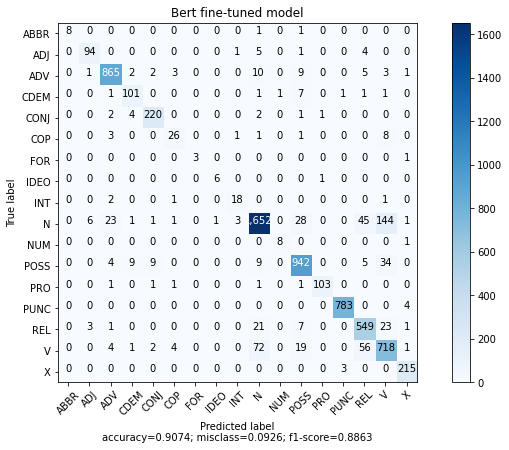

In [22]:
tags = sorted(set(y_true+y_pred))
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(f1_score(y_true, y_pred, average='macro'), cnf_matrix, target_names=tags, title=name, normalize=False)

## Note

**##** label is comming from original-to-tokenized alignment code in function <font color=blue>convert_single_example(ex_index, example, label_list, max_seq_length, tokenizer, mode)</font>  in *bert_pos.py*. Following suggestions from [WordPiece tokenization](https://github.com/google-research/bert) part, for pos tagging task input sentences are converted to the following format:

In [1]:
# orig_tokens = ["John", "Johanson", "'s",  "house"]
# labels      = ["NNP",  "NNP",      "POS", "NN"]

# bert_tokens = ['[CLS]", "john", "johan", "##son", "'",   "s",  "house", "[SEP]"]
# bert_labels = ['[CLS]", "NNP",  "NNP",   "##",    "POS", "##", "NN",    "[SEP]"]